# IDENTIFICATION USING BOTH SURROGATE MODELS - COARSE AND FINE
#  INCREASED NOISE

In this notebook we leverage the pretrained surrogate models to identify fabrication uncertainties in MEMS accelerometers. We start from noisy signals. The noise is an additive white noise, manually added to the data to emulate experimental data. 

##### Importing necessary libraries

In [30]:
# Standard library imports
import sys

# Third-party library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import arviz as az
import timeit
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import load_model


#Try with TinyDA
import tinyDA as tda
from scipy.stats import multivariate_normal
from scipy.stats import uniform

# Local module imports
sys.path.append('../../src/SurrogateModeling')
sys.path.append('../../src/InverseProblems')
sys.path.append('../../src/utils')
from utils import * 

sys.path.append('../../tests/Xaccelerometer_geometric/models')




### Define some helping functions 

In [31]:
def plot_results(time, y_true, y_obs, model, samplesMH, REAL_COLOR='red', LINE_WIDTH=1.5):
    plt.figure()
    plt.plot(1e3*time, y_true, c=REAL_COLOR, label='Real', linewidth=LINE_WIDTH)
    plt.plot(1e3*time, model(np.mean(samplesMH, axis=1)), 'green', label='Pred', linewidth=LINE_WIDTH)
    plt.plot(1e3*time, y_obs, '.-b', label='Noisy Signal', linewidth=LINE_WIDTH)
    plt.plot(1e3*time, model(x_true), 'black', label = 'True parameters')
    plt.xlabel('Time [ms]')
    plt.ylabel(r'$\Delta C$ [fF]')
    plt.title(f'Overetch = {np.mean(samplesMH, axis=1)[0]:.4f}μm; Offset = {np.mean(samplesMH, axis=1)[1]:.4f}μm; Thickness = {np.mean(samplesMH, axis=1)[2]:.4f}μm', fontsize=10)
    plt.legend(loc='upper right', fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

In [32]:
def plot_parameter_distribution(parameter_samples, x_true, parameter_name):
    plt.figure()
    kernel_density = gaussian_kde(parameter_samples)
    x_range = np.linspace(np.min(parameter_samples), np.max(parameter_samples), 1000)
    plt.plot(x_range, kernel_density(x_range), label='Density', linewidth=2)
    plt.axvline(x_true, color='red', label='Exact', linestyle='-', linewidth=2)
    mean, mode = np.mean(parameter_samples), x_range[np.argmax(kernel_density(x_range))]
    plt.axvline(mean, color='green', label='Mean', linestyle='--', linewidth=2)
    plt.axvline(mode, color='blue', label='Mode', linestyle='--', linewidth=2)
    lower_bound, upper_bound = np.percentile(parameter_samples, [2.5, 97.5])
    plt.fill_between(x_range, 0, kernel_density(x_range), where=((x_range >= lower_bound) & (x_range <= upper_bound)), alpha=0.3, color='gray', label='95% C.I.')
    plt.xlabel(parameter_name)
    plt.ylabel('Density')
    plt.legend()
    plt.show()

In [33]:
def plot_histograms(samples, true_params):

    num_params = samples.shape[0]
    param_names = ['Overetch', 'Offset', 'Thickness']

    sigma = [0.4,1,2]
    avgi = [0.3,0.0,30.0]
    sim_avg = ['Oavg','Uavg','Tavg']
    
    for i in range(num_params):
        plt.figure()
        n, bins, _ = plt.hist(samples[i, :], bins=50, density=True, color='skyblue', edgecolor='black')
        mean_value = np.mean(samples[i, :])
        ci_lower, ci_upper = np.percentile(samples[i, :], [5, 95])

        plt.axvline(true_params[i], color='darkred', linestyle='dashed', linewidth=3, label='True')
        plt.axvline(mean_value, color='blue', linestyle='dashed', linewidth=3, label='Mean')
        plt.fill_betweenx([0, max(n)], ci_lower, ci_upper, color='gray', alpha=0.35, label='95% CI')

        ratio_lower = (ci_lower-avgi[i]) / sigma[i]
        ratio_upper = (ci_upper-avgi[i]) / sigma[i]
        sym_lower = ""
        sym_upper = ""
        if ratio_lower>0:
            sym_lower = "+"
        if ratio_upper>0:
            sym_upper = "+"
        s = ['O','U','T']
        #plt.xticks([ci_lower,ci_upper],[sim_avg[i]+sym_lower+f'{ratio_lower:.4f} $\sigma_'+s[i]+'$',sim_avg[i]+sym_upper+f'{ratio_upper:.4f} $\sigma_'+s[i]+'$'])
        plt.xticks([ci_lower,ci_upper],[round(ci_lower,3), round(ci_upper,3)], fontsize = 12)
        plt.xlabel(param_names[i], fontsize=14)
        plt.ylabel('Density', fontsize=14)
        plt.legend()
        plt.grid(True)
        plt.show()

#### Decide sample to use for experimental data

In [34]:
sample = 110 # Which sample of the training set do wou want to take as experimental input?
OUTPUT_FILENAME = "./samples/sample_"+str(sample)

#### Set Bayesian Identification Parameters

In [35]:
# Surrogate Model Configurations
CONFIGURATION_I = './config_I.json'
CONFIGURATION_II = './config_II.json'

# Markov Chain Monte Carlo (MCMC) Configuration
MCMC_SETTINGS = {
    'parameter_start_points': [
        np.array([0.3, 0.0, 30.0]),
        np.array([0.4, 0.25, 30.0]),
        np.array([0.2, 0.25, 30.0]),
        np.array([0.4, -0.25, 30.0]),
        np.array([0.2, -0.25, 30.0])
    ],
    'bounds': ([0.1, -0.5, 29.0], [0.5, 0.5, 31.0]),
    'N': int(6e3),   # Total number of samples
    'Nb': int(1e3),  # Number of burn-in samples
    'Nt': 5,         # Number of chains
}

# Noise Configuration
NOISE_PARAMS = {
    'noise_factor': 1e-6 * 10000,
    'B': np.sqrt(200),
    'S': 5,
}

noise = (NOISE_PARAMS['noise_factor']*NOISE_PARAMS['B']*NOISE_PARAMS['S'])**2
print( 'The standard deviation of the noise is: ', noise)


The standard deviation of the noise is:  0.4999999999999999


#### Load Surrogate Models

Load fine model 

In [36]:
# Data preprocessing for both configurations
data_processor_I = preprocessing(CONFIGURATION_I)
data_processor_II = preprocessing(CONFIGURATION_II)

# Load Fine model 
# Initialize and load models for both configurations
model_I = NN_Model()
model_I.load_model(data_processor_I.config['MODEL_PATH'])
# Define forward and gradient functions for the first configuration
fine_model = create_forward_model_function(data_processor_I, model_I)

Load coarse model 

In [37]:
# Import the function coarse_model
from coarse_model import *

num_samples = 640
num_parameters = 3
num_coarse_values = 75
# Define the neural network model
model_lowfidelity_NN = Sequential([
        Dense(150,input_shape=(num_parameters + num_coarse_values,),activation='linear')
       ])
# Load the model
model_lowfidelity_NN = load_model('./models/model_LF_NN_oo3.keras')
model_lf = create_model_LF_NN_oo3_opt()

/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


load the data 

In [38]:
# Extract test data for visualization or further processing
X_values, y_values = data_processor_I.X_test, data_processor_I.y_test

### Define Priors and Likelyhoods

 Define a custom Uniform random variable class

In [39]:
class CustomUniform:
    def __init__(self, lower_bound, upper_bound):
        self.lower_bound = lower_bound
        self.upper_bound = upper_bound
        self.area = np.prod(self.upper_bound - self.lower_bound)
    
    def pdf(self, x):
        if (self.lower_bound <= x).all() & (x <= self.upper_bound).all():
            return 1 / self.area
        else:
            return 0
        
    def logpdf(self, x):   
        if  self.pdf(x)==0:
            return -np.inf
        else:
            return np.log(self.pdf(x))
    
    def rvs(self):
        return np.random.uniform(self.lower_bound, self.upper_bound)



In [40]:
# Select a true sample for testing
x_true, y_true = X_values[sample], y_values[sample]
# Generate observed data by adding Gaussian noise to the true data
y_observed = y_true + np.random.normal(scale=np.sqrt(noise),size=y_true.shape[0]) 

# Define the prior distribution for the input parameters
# Assuming uniform distributions over specified ranges for each parameter
x_distribution = CustomUniform(np.array([0.1, -0.5, 29.0]), np.array([0.5, 0.5, 31.0]))

# Pass the sampled input to the forward model
# set the likelihood
cov_likelihood = noise * np.eye(len(data_processor_I.time))
y_distr_fine = tda.GaussianLogLike(y_observed, cov_likelihood) 

#points = np.linspace(0,0.0015-1e-5,150)
#phi = lambda t: np.abs(np.cos(2*np.pi*2500*t)) if t < 2.25/2500 and t > 0.25/2500 else 0
#coeff = [1+10*phi(t-1e-5*10) for t in points]
y_distr_coarse = tda.GaussianLogLike(y_observed, cov_likelihood*10)

### Define a Posterior

In [41]:
# initialise the LinkFactory
my_posterior_coarse = tda.Posterior(x_distribution, y_distr_coarse, coarse_model)
my_posterior_fine = tda.Posterior(x_distribution, y_distr_fine, fine_model)

my_posteriors = [my_posterior_coarse, my_posterior_fine]



#### Perform least square optimization for each starting point

In [79]:
# Initialize a list to hold the optimized parameters for each start point
initial_guesses = []

# Display the true parameters for reference
print("Real Params: ", x_true)

# Iterate over each parameter start point to perform optimization
for index, start_point in enumerate(MCMC_SETTINGS['parameter_start_points']):
    # Perform least squares optimization given the observed data, forward model,
    # start point, and parameter bounds
    optimized_params, covariance_matrix = least_squares_optimization(
        y_observed=y_observed, 
        forward_model=model_lf, 
        start_point=start_point, 
        bounds=MCMC_SETTINGS['bounds']
    )

    # Append the optimized parameters to the list of initial guesses
    initial_guesses.append(optimized_params)

    # Print the optimized parameters for this iteration
    print(f"Optimized Params {index + 1}: {optimized_params}")

# covariance_matrix = np.eye(3)*(np.diag(covariance_matrix))
print('\nWe are using the following covariance matrix\n', covariance_matrix)


Real Params:  [ 0.368893  0.033376 29.525593]
Optimized Params 1: [ 0.37391641  0.03193582 30.88042419]
Optimized Params 2: [ 0.37391642  0.03193581 30.88042578]
Optimized Params 3: [ 0.37391645  0.03193581 30.88042998]
Optimized Params 4: [ 0.37391642  0.03193581 30.88042569]
Optimized Params 5: [ 0.37391645  0.03193581 30.88043003]

We are using the following covariance matrix
 [[ 2.96236084e-04 -1.17625696e-05  2.48052308e-02]
 [-1.17625696e-05  3.09206754e-06 -2.58301417e-03]
 [ 2.48052308e-02 -2.58301417e-03  3.16703181e+00]]


Set up the proposal

In [43]:
# Adaptive Metropolis
my_proposal = tda.GaussianRandomWalk(C=covariance_matrix, scaling= 0.2)


### Do Metropolis Hastings Sampling - MDA Fine - Euler 

In [44]:
# Initialize a list to hold the Markov chain samples for each initial guess
samples_mh = []
ESS_values = []
# Iterate over each initial guess to set up and run the Markov chain sampler\n",
start_0 = timeit.default_timer() 
for index, initial_guess in enumerate(initial_guesses):
    samples = tda.sample(my_posteriors, my_proposal, 
                             iterations=2100, n_chains=1,
                               initial_parameters=initial_guess, 
                           subsampling_rate = 30) #adaptive_error_model='state-independent')
    idata = tda.to_inference_data(samples, level='fine', parameter_names= ['Overetch', 'Offset', 'Thickness'])
    # Remove the burnin and sub-sample
    idata = idata.sel(draw=slice(100, None, 3), groups="posterior")
    # Append the samples to the list\n",
    samples_mh.append(idata)
    # Compute and print the Effective Sample Size (ESS) of the first set of samples\n",
    print("Effective Sample Size: ", az.ess(samples_mh[index]),"\n")
    ess = az.ess(idata)
    ESS_values.append([ess['Overetch'].values, ess['Offset'].values, ess['Thickness'].values])

end_0 = timeit.default_timer() 
# Computing diagnostics and collecting results\n",
print("Rhat: ", az.rhat(az.concat(samples_mh, dim = 'chain')) ) 

print("\nThe average ESS is: ", np.mean(ESS_values, axis = 0 ) ) 
print('Time/ESS MDA',(end_0-start_0)/(5*np.mean(ESS_values, axis = 0) ))

# Save the numpy array to a file
np.save(OUTPUT_FILENAME, np.array([samples_mh[0].posterior['Overetch'].values[0], samples_mh[0].posterior['Offset'].values[0], samples_mh[0].posterior['Thickness'].values[0] ]) )  



Sampling chain 1/1


Running chain, α_c = 0.803, α_f = 0.46: 100%|██████████| 2100/2100 [00:11<00:00, 180.73it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Effective Sample Size:  <xarray.Dataset> Size: 24B
Dimensions:    ()
Data variables:
    Overetch   float64 8B 297.2
    Offset     float64 8B 236.5
    Thickness  float64 8B 317.5 

Sampling chain 1/1


Running chain, α_c = 0.791, α_f = 0.45: 100%|██████████| 2100/2100 [00:11<00:00, 182.34it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Effective Sample Size:  <xarray.Dataset> Size: 24B
Dimensions:    ()
Data variables:
    Overetch   float64 8B 260.0
    Offset     float64 8B 158.3
    Thickness  float64 8B 220.7 

Sampling chain 1/1


Running chain, α_c = 0.783, α_f = 0.40: 100%|██████████| 2100/2100 [00:11<00:00, 178.80it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Effective Sample Size:  <xarray.Dataset> Size: 24B
Dimensions:    ()
Data variables:
    Overetch   float64 8B 259.4
    Offset     float64 8B 225.3
    Thickness  float64 8B 295.5 

Sampling chain 1/1


Running chain, α_c = 0.792, α_f = 0.41: 100%|██████████| 2100/2100 [00:11<00:00, 178.25it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Effective Sample Size:  <xarray.Dataset> Size: 24B
Dimensions:    ()
Data variables:
    Overetch   float64 8B 309.8
    Offset     float64 8B 294.3
    Thickness  float64 8B 333.2 

Sampling chain 1/1


Running chain, α_c = 0.789, α_f = 0.38: 100%|██████████| 2100/2100 [00:12<00:00, 173.92it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Effective Sample Size:  <xarray.Dataset> Size: 24B
Dimensions:    ()
Data variables:
    Overetch   float64 8B 243.8
    Offset     float64 8B 206.9
    Thickness  float64 8B 260.7 

Rhat:  <xarray.Dataset> Size: 24B
Dimensions:    ()
Data variables:
    Overetch   float64 8B 1.003
    Offset     float64 8B 1.004
    Thickness  float64 8B 1.004

The average ESS is:  [274.04407495 224.23523011 285.52008555]
Time/ESS MDA [0.04315474 0.0527406  0.0414202 ]


### Diagnostics - MDA

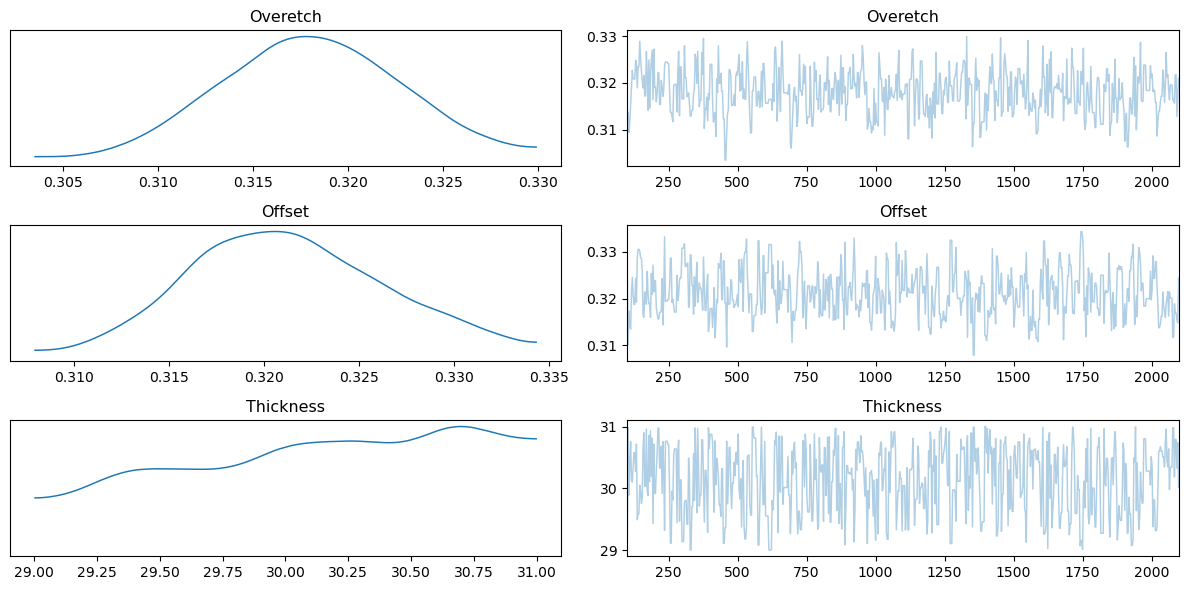

In [45]:
# Plot trace of the first set of samples
idata = samples_mh[0]
az.plot_trace(idata)
plt.tight_layout()
plt.show()


Let's compare the prediction of the mean parameter combination and the experimental signal

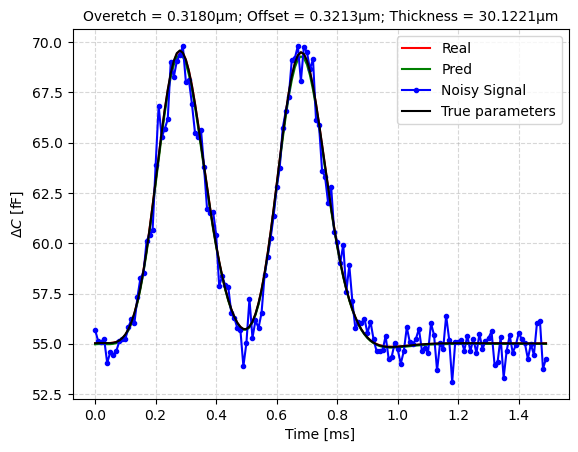

In [46]:
# Plotting and data collection
data = np.array([idata.posterior['Overetch'].values[0], idata.posterior['Offset'].values[0], idata.posterior['Thickness'].values[0] ]) 
plot_results(data_processor_I.time, y_true, y_observed, fine_model, data)

Finally, let's look at the parameters distribution

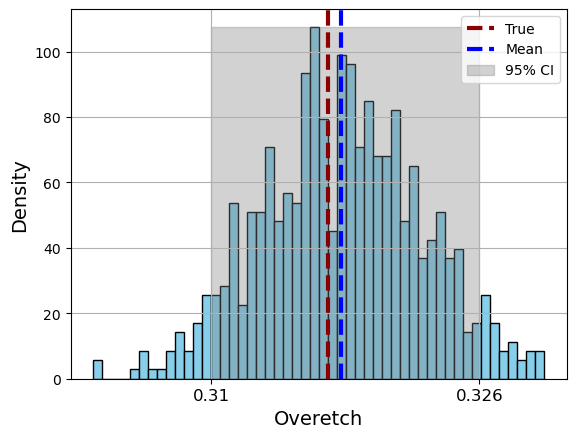

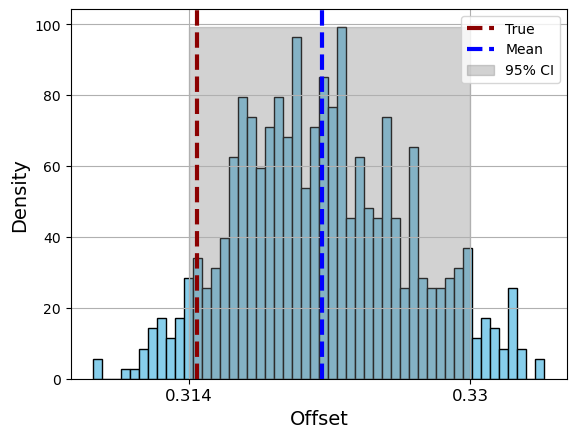

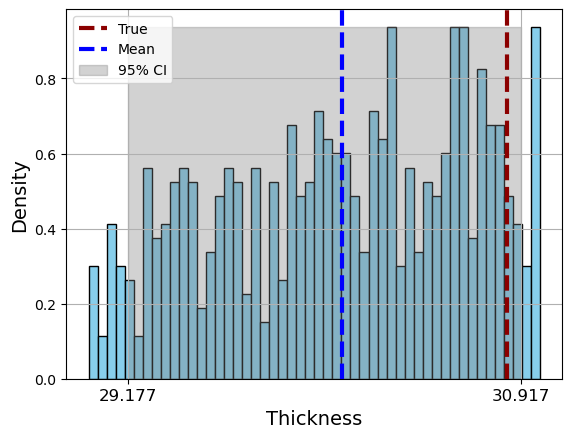

In [47]:
plot_histograms(data, x_true)

### Do Metropolis Hastings - MDA Euler-Adjusted

In [86]:
# initialise the LinkFactory
my_posterior_coarse = tda.Posterior(x_distribution, y_distr_coarse, coarse_model)
my_posterior_fine = tda.Posterior(x_distribution, y_distr_fine, model_lf)
my_posteriors = [my_posterior_coarse, my_posterior_fine]

# Adaptive Metropolis
my_proposal = tda.GaussianRandomWalk(C=covariance_matrix, scaling= 0.8)

In [91]:
# Initialize a list to hold the Markov chain samples for each initial guess
samples_mh = []
ESS_values = []
# Iterate over each initial guess to set up and run the Markov chain sampler\n",
start_0 = timeit.default_timer() 
for index, initial_guess in enumerate(initial_guesses):
    samples = tda.sample(my_posteriors, my_proposal, 
                             iterations=2250, n_chains=1,
                               initial_parameters=initial_guess, 
                           subsampling_rate = 3) #adaptive_error_model='state-independent')
    idata = tda.to_inference_data(samples, level='fine', parameter_names= ['Overetch', 'Offset', 'Thickness'])
    # Remove the burnin and sub-sample
    idata = idata.sel(draw=slice(250, None, 3), groups="posterior")
    # Append the samples to the list\n",
    samples_mh.append(idata)
    # Compute and print the Effective Sample Size (ESS) of the first set of samples\n",
    print("Effective Sample Size: ", az.ess(samples_mh[index]),"\n")
    ess = az.ess(idata)
    ESS_values.append([ess['Overetch'].values, ess['Offset'].values, ess['Thickness'].values])

end_0 = timeit.default_timer() 
# Computing diagnostics and collecting results\n",
print("Rhat: ", az.rhat(az.concat(samples_mh, dim = 'chain')) ) 

print("\nThe average ESS is: ", np.mean(ESS_values, axis = 0 ) ) 
print('Time/ESS MDA',(end_0-start_0)/(5*np.mean(ESS_values, axis = 0) ))

# Save the numpy array to a file
np.save(OUTPUT_FILENAME, np.array([samples_mh[0].posterior['Overetch'].values[0], samples_mh[0].posterior['Offset'].values[0], samples_mh[0].posterior['Thickness'].values[0] ]) )  


Sampling chain 1/1


Running chain, α_c = 0.363, α_f = 0.39: 100%|██████████| 2250/2250 [00:02<00:00, 832.58it/s] 
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Effective Sample Size:  <xarray.Dataset> Size: 24B
Dimensions:    ()
Data variables:
    Overetch   float64 8B 289.3
    Offset     float64 8B 175.7
    Thickness  float64 8B 398.1 

Sampling chain 1/1


Running chain, α_c = 0.353, α_f = 0.32: 100%|██████████| 2250/2250 [00:02<00:00, 1007.19it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Effective Sample Size:  <xarray.Dataset> Size: 24B
Dimensions:    ()
Data variables:
    Overetch   float64 8B 215.2
    Offset     float64 8B 272.0
    Thickness  float64 8B 340.1 

Sampling chain 1/1


Running chain, α_c = 0.363, α_f = 0.37: 100%|██████████| 2250/2250 [00:02<00:00, 1052.04it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Effective Sample Size:  <xarray.Dataset> Size: 24B
Dimensions:    ()
Data variables:
    Overetch   float64 8B 254.1
    Offset     float64 8B 171.5
    Thickness  float64 8B 332.1 

Sampling chain 1/1


Running chain, α_c = 0.397, α_f = 0.36: 100%|██████████| 2250/2250 [00:02<00:00, 1116.26it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Effective Sample Size:  <xarray.Dataset> Size: 24B
Dimensions:    ()
Data variables:
    Overetch   float64 8B 210.5
    Offset     float64 8B 310.1
    Thickness  float64 8B 346.0 

Sampling chain 1/1


Running chain, α_c = 0.387, α_f = 0.38: 100%|██████████| 2250/2250 [00:02<00:00, 1027.51it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Effective Sample Size:  <xarray.Dataset> Size: 24B
Dimensions:    ()
Data variables:
    Overetch   float64 8B 171.7
    Offset     float64 8B 176.1
    Thickness  float64 8B 303.3 

Rhat:  <xarray.Dataset> Size: 24B
Dimensions:    ()
Data variables:
    Overetch   float64 8B 1.003
    Offset     float64 8B 1.002
    Thickness  float64 8B 1.002

The average ESS is:  [228.14155886 221.08950097 343.91367545]
Time/ESS MDA [0.01006096 0.01038187 0.00667412]


### Diagnostics - MDA Euler - Adj

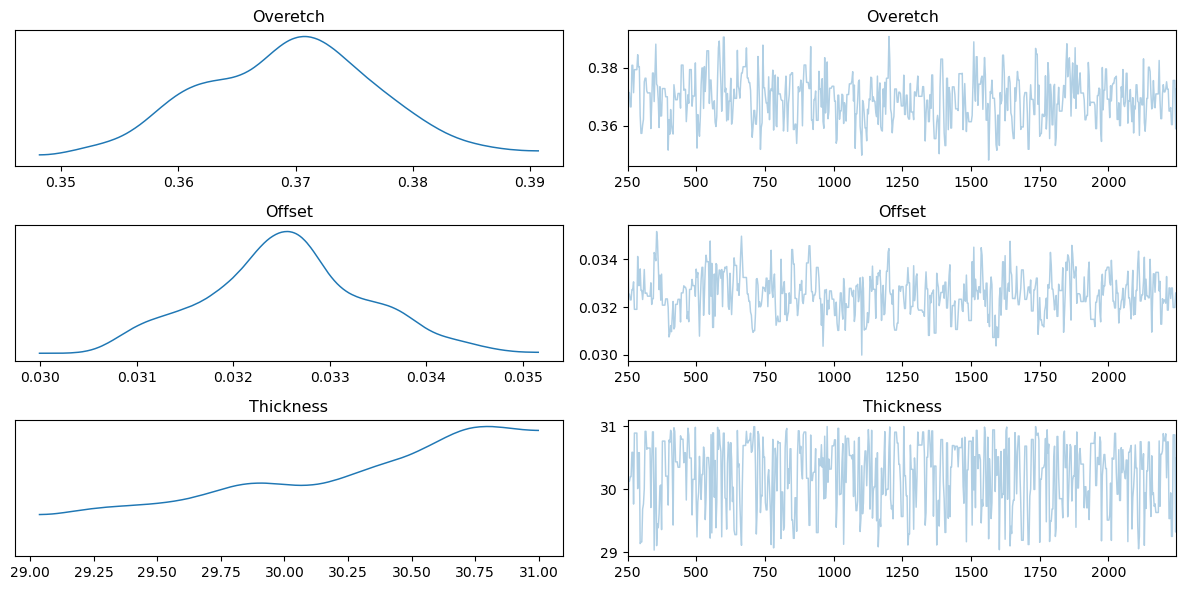

In [93]:
# Plot trace of the first set of samples
idata = samples_mh[0]
az.plot_trace(idata)
plt.tight_layout()
plt.show()

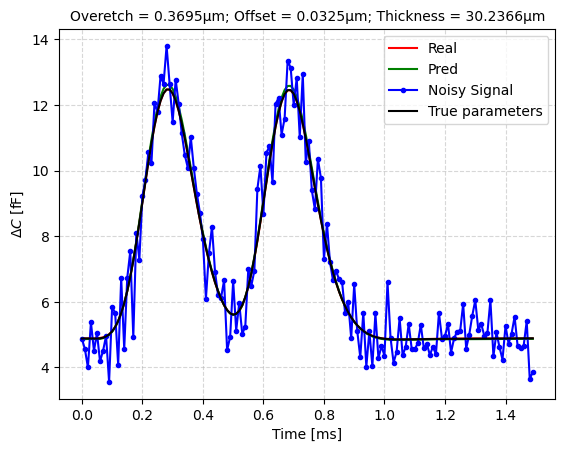

In [94]:
# Plotting and data collection
data = np.array([idata.posterior['Overetch'].values[0], idata.posterior['Offset'].values[0], idata.posterior['Thickness'].values[0] ]) 
plot_results(data_processor_I.time, y_true, y_observed, fine_model, data)

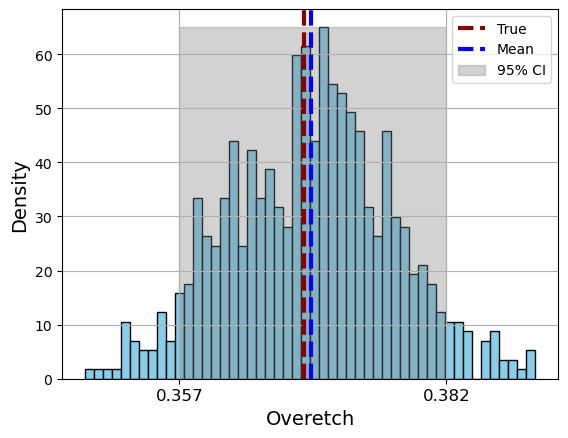

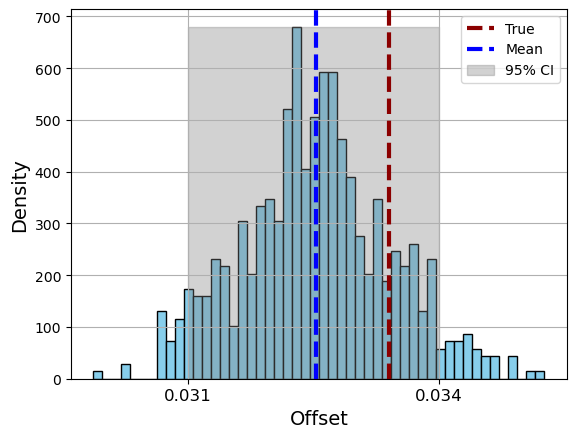

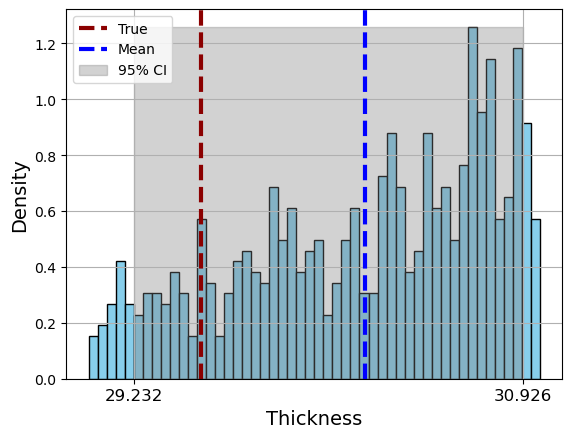

In [95]:
plot_histograms(data, x_true)

### Do Metropolis Hastings - FINE ONLY

In [48]:
my_proposal_fine = tda.GaussianRandomWalk(C=covariance_matrix, scaling = 0.8)

# Initialize a list to hold the Markov chain samples for each initial guess
samples_mh = []
ESS_values = []
# Iterate over each initial guess to set up and run the Markov chain sampler\n",
start_0 = timeit.default_timer() 
for index, initial_guess in enumerate(initial_guesses):
    samples = tda.sample(my_posterior_fine, my_proposal_fine, 
                             iterations=6000, n_chains=1,
                               initial_parameters=initial_guess) #adaptive_error_model='state-independent')
    idata = tda.to_inference_data(samples, level='fine', parameter_names= ['Overetch', 'Offset', 'Thickness'])
    # Remove the burnin and sub-sample
    idata = idata.sel(draw=slice(1000, None, 5), groups="posterior")
    # Append the samples to the list\n",
    samples_mh.append(idata)
    # Compute and print the Effective Sample Size (ESS) of the first set of samples\n",
    print("Effective Sample Size: ", az.ess(samples_mh[index]),"\n")
    ess = az.ess(idata)
    ESS_values.append([ess['Overetch'].values, ess['Offset'].values, ess['Thickness'].values])
end_0 = timeit.default_timer() 

# Computing diagnostics and collecting results\n",
print("Rhat: ", az.rhat(az.concat(samples_mh, dim = 'chain')) ) 

print("\nThe average ESS is: ", np.mean(ESS_values, axis = 0 ) ) 
print('Time/ESS MDA',(end_0-start_0)/(5*np.mean(ESS_values, axis = 0) ))
# Save the numpy array to a file
np.save(OUTPUT_FILENAME, np.array([samples_mh[0].posterior['Overetch'].values[0], samples_mh[0].posterior['Offset'].values[0], samples_mh[0].posterior['Thickness'].values[0] ]) )  



Sampling chain 1/1


Running chain, α = 0.25: 100%|██████████| 6000/6000 [00:22<00:00, 269.83it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Effective Sample Size:  <xarray.Dataset> Size: 24B
Dimensions:    ()
Data variables:
    Overetch   float64 8B 295.4
    Offset     float64 8B 219.0
    Thickness  float64 8B 300.6 

Sampling chain 1/1


Running chain, α = 0.17: 100%|██████████| 6000/6000 [00:22<00:00, 269.62it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Effective Sample Size:  <xarray.Dataset> Size: 24B
Dimensions:    ()
Data variables:
    Overetch   float64 8B 329.1
    Offset     float64 8B 240.5
    Thickness  float64 8B 312.0 

Sampling chain 1/1


Running chain, α = 0.19: 100%|██████████| 6000/6000 [00:22<00:00, 269.64it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Effective Sample Size:  <xarray.Dataset> Size: 24B
Dimensions:    ()
Data variables:
    Overetch   float64 8B 289.5
    Offset     float64 8B 243.1
    Thickness  float64 8B 299.3 

Sampling chain 1/1


Running chain, α = 0.22: 100%|██████████| 6000/6000 [00:22<00:00, 272.00it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Effective Sample Size:  <xarray.Dataset> Size: 24B
Dimensions:    ()
Data variables:
    Overetch   float64 8B 181.6
    Offset     float64 8B 300.5
    Thickness  float64 8B 355.2 

Sampling chain 1/1


Running chain, α = 0.25: 100%|██████████| 6000/6000 [00:21<00:00, 274.23it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Effective Sample Size:  <xarray.Dataset> Size: 24B
Dimensions:    ()
Data variables:
    Overetch   float64 8B 220.4
    Offset     float64 8B 164.2
    Thickness  float64 8B 274.6 

Rhat:  <xarray.Dataset> Size: 24B
Dimensions:    ()
Data variables:
    Overetch   float64 8B 1.002
    Offset     float64 8B 1.003
    Thickness  float64 8B 1.002

The average ESS is:  [263.21384195 233.44022443 308.33140354]
Time/ESS MDA [0.08423876 0.09498281 0.07191226]


### Diagnostics - FINE

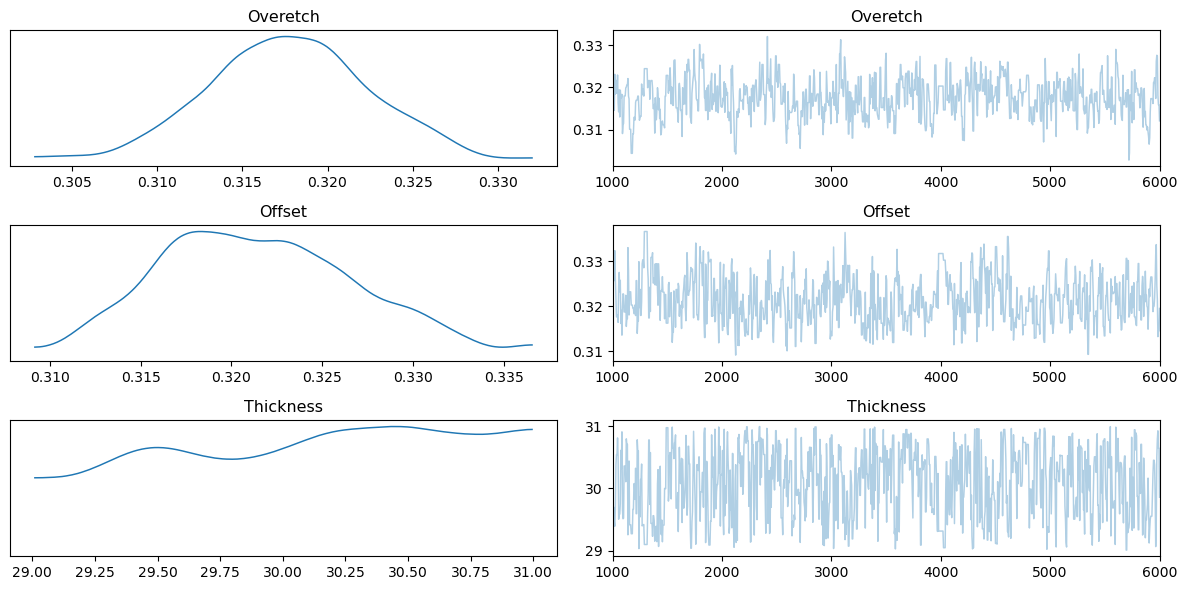

In [49]:
az.plot_trace(idata)
plt.tight_layout()
plt.show()

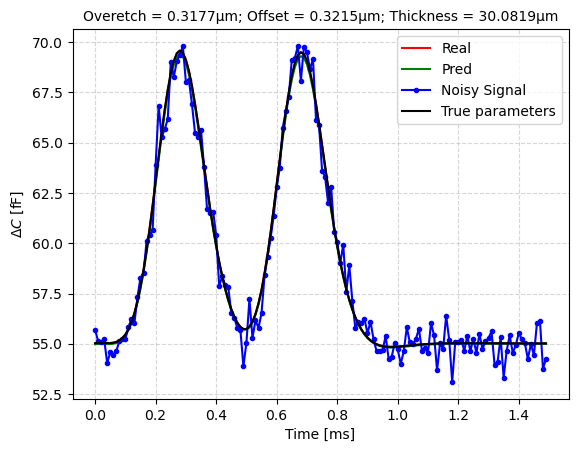

In [50]:
# Plotting and data collection
data = np.array([idata.posterior['Overetch'].values[0], idata.posterior['Offset'].values[0], idata.posterior['Thickness'].values[0] ]) 
plot_results(data_processor_I.time, y_true, y_observed, fine_model, data)

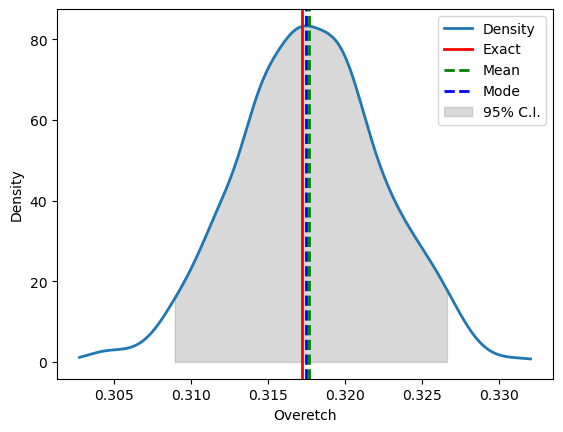

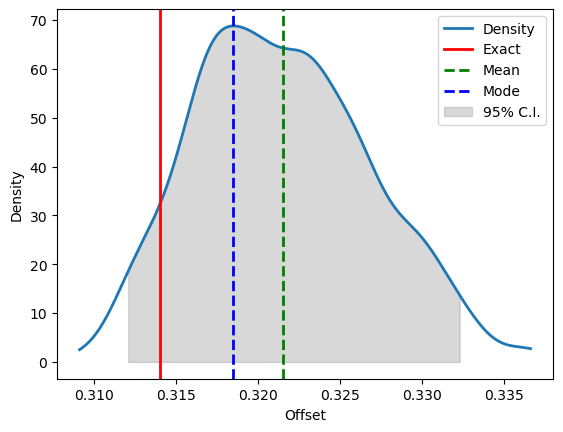

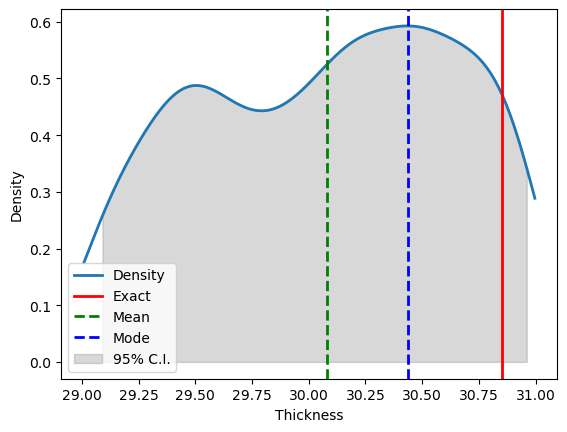

In [51]:
for j in range(3):
    plot_parameter_distribution(data[j,:], x_true[j], ['Overetch', 'Offset', 'Thickness'][j])

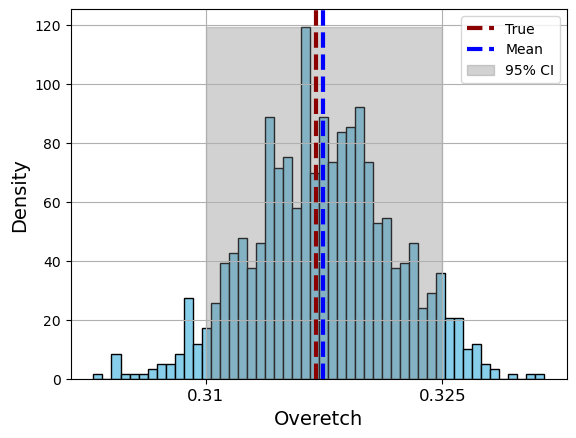

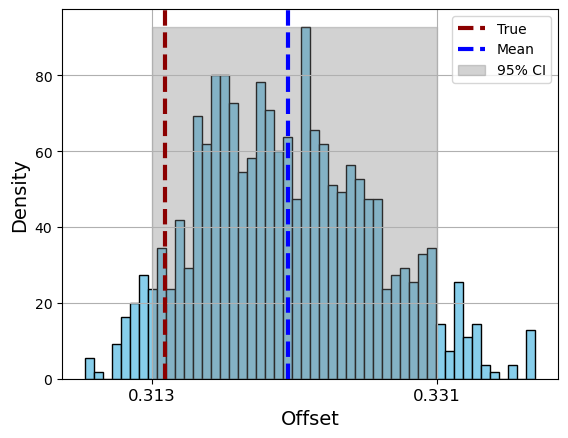

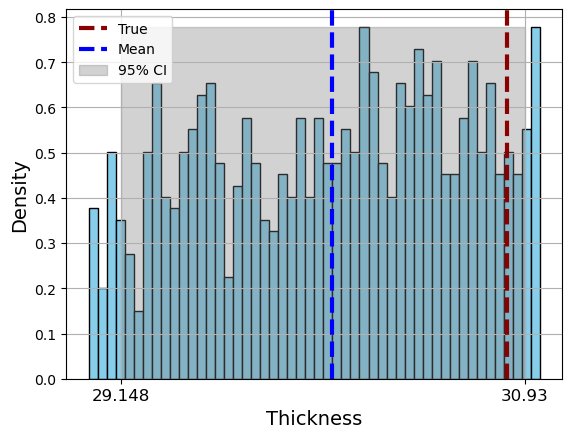

In [52]:
plot_histograms(data, x_true)

### Metropolis Hasting - Adjusted 

In [97]:
my_proposal_fine = tda.GaussianRandomWalk(C=covariance_matrix, scaling = 0.8)

# Initialize a list to hold the Markov chain samples for each initial guess
samples_mh = []
ESS_values = []
# Iterate over each initial guess to set up and run the Markov chain sampler\n",
my_posterior = tda.Posterior(x_distribution, y_distr_fine, model_lf)
start_0 = timeit.default_timer() 
for index, initial_guess in enumerate(initial_guesses):
    samples = tda.sample(my_posterior, my_proposal, 
                             iterations=6000, n_chains=1,
                               initial_parameters=initial_guess) #adaptive_error_model='state-independent')
    idata = tda.to_inference_data(samples, level='fine', parameter_names= ['Overetch', 'Offset', 'Thickness'])
    # Remove the burnin and sub-sample
    idata = idata.sel(draw=slice(1000, None, 5), groups="posterior")
    # Append the samples to the list\n",
    samples_mh.append(idata)
    # Compute and print the Effective Sample Size (ESS) of the first set of samples\n",
    print("Effective Sample Size: ", az.ess(samples_mh[index]),"\n")
    ess = az.ess(idata)
    ESS_values.append([ess['Overetch'].values, ess['Offset'].values, ess['Thickness'].values])
end_0 = timeit.default_timer() 

# Computing diagnostics and collecting results\n",
print("Rhat: ", az.rhat(az.concat(samples_mh, dim = 'chain')) ) 

print("\nThe average ESS is: ", np.mean(ESS_values, axis = 0 ) ) 
print('Time/ESS MDA',(end_0-start_0)/(5*np.mean(ESS_values, axis = 0) ))
# Save the numpy array to a file
np.save(OUTPUT_FILENAME, np.array([samples_mh[0].posterior['Overetch'].values[0], samples_mh[0].posterior['Offset'].values[0], samples_mh[0].posterior['Thickness'].values[0] ]) )  



Sampling chain 1/1


Running chain, α = 0.29: 100%|██████████| 6000/6000 [00:05<00:00, 1144.82it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Effective Sample Size:  <xarray.Dataset> Size: 24B
Dimensions:    ()
Data variables:
    Overetch   float64 8B 322.8
    Offset     float64 8B 228.2
    Thickness  float64 8B 480.4 

Sampling chain 1/1


Running chain, α = 0.25: 100%|██████████| 6000/6000 [00:04<00:00, 1288.85it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Effective Sample Size:  <xarray.Dataset> Size: 24B
Dimensions:    ()
Data variables:
    Overetch   float64 8B 257.7
    Offset     float64 8B 221.5
    Thickness  float64 8B 433.1 

Sampling chain 1/1


Running chain, α = 0.21: 100%|██████████| 6000/6000 [00:04<00:00, 1297.39it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Effective Sample Size:  <xarray.Dataset> Size: 24B
Dimensions:    ()
Data variables:
    Overetch   float64 8B 378.4
    Offset     float64 8B 312.1
    Thickness  float64 8B 415.0 

Sampling chain 1/1


Running chain, α = 0.19: 100%|██████████| 6000/6000 [00:04<00:00, 1350.61it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Effective Sample Size:  <xarray.Dataset> Size: 24B
Dimensions:    ()
Data variables:
    Overetch   float64 8B 279.1
    Offset     float64 8B 330.6
    Thickness  float64 8B 476.3 

Sampling chain 1/1


Running chain, α = 0.28: 100%|██████████| 6000/6000 [00:04<00:00, 1310.75it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Effective Sample Size:  <xarray.Dataset> Size: 24B
Dimensions:    ()
Data variables:
    Overetch   float64 8B 309.1
    Offset     float64 8B 319.4
    Thickness  float64 8B 617.9 

Rhat:  <xarray.Dataset> Size: 24B
Dimensions:    ()
Data variables:
    Overetch   float64 8B 1.003
    Offset     float64 8B 1.003
    Thickness  float64 8B 1.001

The average ESS is:  [309.42698321 282.33401349 484.53923988]
Time/ESS MDA [0.01534465 0.01681713 0.0097991 ]


### Diagnostics Adjusted 

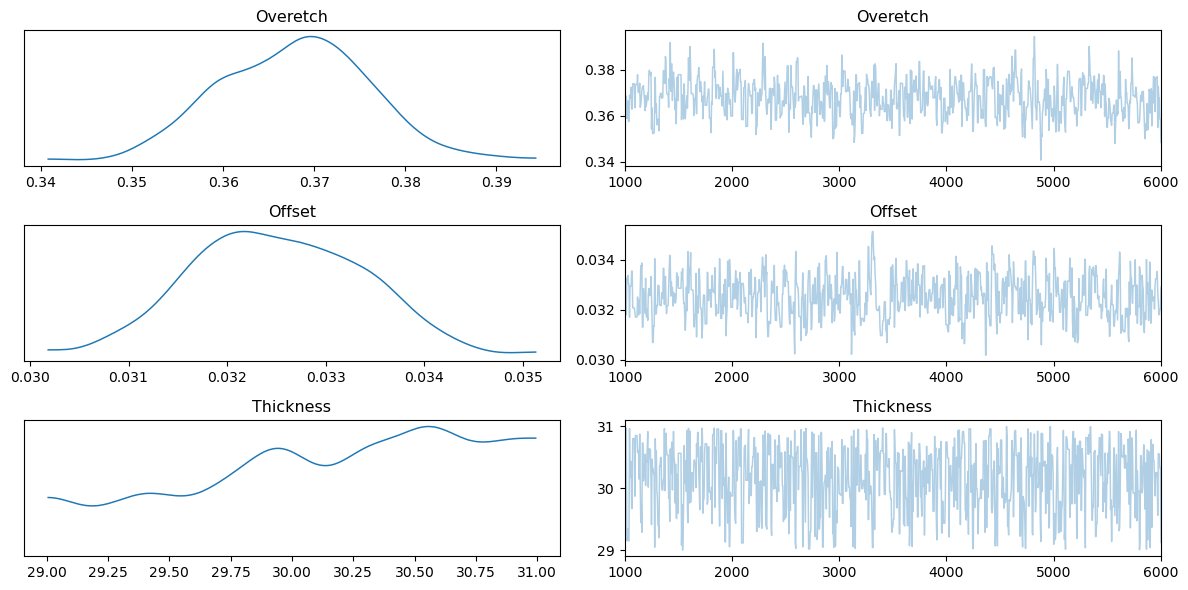

In [98]:
az.plot_trace(idata)
plt.tight_layout()
plt.show()

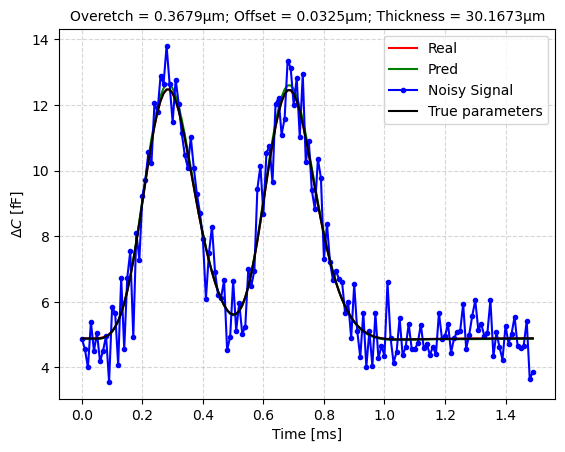

In [99]:
# Plotting and data collection
data = np.array([idata.posterior['Overetch'].values[0], idata.posterior['Offset'].values[0], idata.posterior['Thickness'].values[0] ]) 
plot_results(data_processor_I.time, y_true, y_observed, fine_model, data)

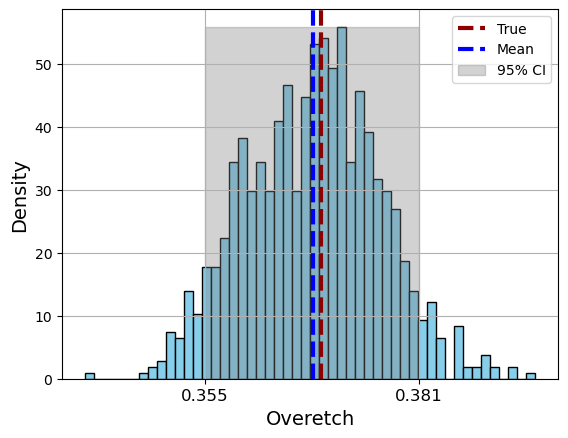

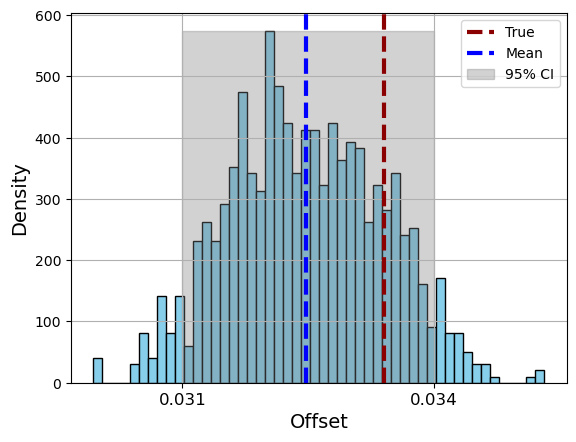

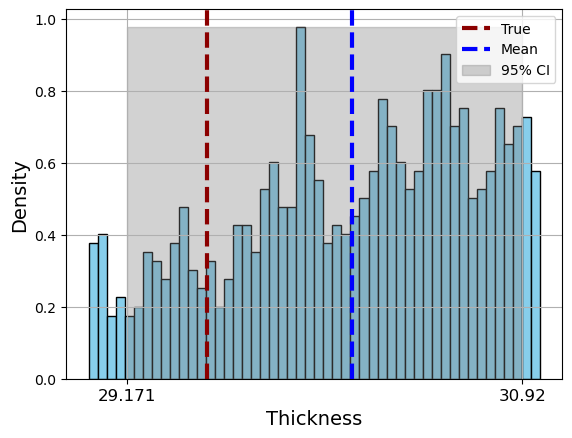

In [100]:
plot_histograms(data, x_true)

### Gridsearch ideal parameters 

In [58]:
subsampling_rate_values = [1, 2, 3, 5 ,7, 10 ]
scaling_values = [ 0.3, 0.5, 0.7, 0.8, 0.9, 1 ]

In [59]:
M = np.zeros((len(subsampling_rate_values), len(scaling_values)))


for index1, ssr in enumerate(subsampling_rate_values):
    for index2, scale in enumerate(scaling_values): 
        # Adaptive Metropolis
        my_proposal = tda.GaussianRandomWalk(C=covariance_matrix, scaling= scale)
        # Initialize a list to hold the Effective sample sizes for each initial guess
        ESS_values = []
        # Iterate over each initial guess to set up and run the Markov chain sampler
        for index, initial_guess in enumerate(initial_guesses[0:2]):
            samples = tda.sample(my_posteriors, my_proposal, 
                         iterations=4000, n_chains=1,
                           initial_parameters=initial_guess, 
                           subsampling_rate = ssr)
                           #adaptive_error_model='state-independent')
            idata = tda.to_inference_data(samples, level='fine', parameter_names= ['Overetch', 'Offset', 'Thickness'])
            # Remove the burnin and sub-sample
            idata = idata.sel(draw=slice(250, None, 5), groups="posterior")
            ess = az.ess(idata)
            ESS_values.append((ess['Overetch'].values + ess['Offset'].values + ess['Thickness'].values)/3)
            if(index==1):
                print('sampled with params: ', ssr, scale, '   done ', index2+1 + index1*len(scaling_values), '/', len(scaling_values)*len(subsampling_rate_values))

        # Add the mean of the different sample sizes to the matrix
        M[index1, index2] = np.mean(ESS_values)

Sampling chain 1/1


Running chain, α_c = 0.803, α_f = 0.77: 100%|██████████| 4000/4000 [00:04<00:00, 925.67it/s] 
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.793, α_f = 0.72: 100%|██████████| 4000/4000 [00:04<00:00, 905.37it/s] 
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  3 0.2    done  1 / 36
Sampling chain 1/1


Running chain, α_c = 0.717, α_f = 0.79: 100%|██████████| 4000/4000 [00:04<00:00, 884.00it/s] 
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.700, α_f = 0.62: 100%|██████████| 4000/4000 [00:04<00:00, 880.64it/s] 
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  3 0.3    done  2 / 36
Sampling chain 1/1


Running chain, α_c = 0.530, α_f = 0.48: 100%|██████████| 4000/4000 [00:04<00:00, 877.89it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.540, α_f = 0.45: 100%|██████████| 4000/4000 [00:04<00:00, 895.19it/s] 
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  3 0.5    done  3 / 36
Sampling chain 1/1


Running chain, α_c = 0.450, α_f = 0.38: 100%|██████████| 4000/4000 [00:04<00:00, 854.42it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.383, α_f = 0.35: 100%|██████████| 4000/4000 [00:04<00:00, 888.78it/s] 
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  3 0.7    done  4 / 36
Sampling chain 1/1


Running chain, α_c = 0.363, α_f = 0.29: 100%|██████████| 4000/4000 [00:04<00:00, 868.92it/s] 
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.320, α_f = 0.25: 100%|██████████| 4000/4000 [00:04<00:00, 886.19it/s] 
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  3 0.8    done  5 / 36
Sampling chain 1/1


Running chain, α_c = 0.327, α_f = 0.37: 100%|██████████| 4000/4000 [00:04<00:00, 874.78it/s] 
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.283, α_f = 0.24: 100%|██████████| 4000/4000 [00:04<00:00, 874.74it/s] 
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  3 1    done  6 / 36
Sampling chain 1/1


Running chain, α_c = 0.780, α_f = 0.55: 100%|██████████| 4000/4000 [00:05<00:00, 774.32it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.808, α_f = 0.71: 100%|██████████| 4000/4000 [00:05<00:00, 786.09it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  5 0.2    done  7 / 36
Sampling chain 1/1


Running chain, α_c = 0.642, α_f = 0.57: 100%|██████████| 4000/4000 [00:05<00:00, 706.81it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.728, α_f = 0.56: 100%|██████████| 4000/4000 [00:05<00:00, 748.56it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  5 0.3    done  8 / 36
Sampling chain 1/1


Running chain, α_c = 0.522, α_f = 0.50: 100%|██████████| 4000/4000 [00:05<00:00, 748.25it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.526, α_f = 0.40: 100%|██████████| 4000/4000 [00:05<00:00, 719.83it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  5 0.5    done  9 / 36
Sampling chain 1/1


Running chain, α_c = 0.454, α_f = 0.36: 100%|██████████| 4000/4000 [00:05<00:00, 765.97it/s] 
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.424, α_f = 0.35: 100%|██████████| 4000/4000 [00:05<00:00, 791.33it/s] 
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  5 0.7    done  10 / 36
Sampling chain 1/1


Running chain, α_c = 0.390, α_f = 0.33: 100%|██████████| 4000/4000 [00:05<00:00, 735.25it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.424, α_f = 0.33: 100%|██████████| 4000/4000 [00:05<00:00, 741.43it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  5 0.8    done  11 / 36
Sampling chain 1/1


Running chain, α_c = 0.294, α_f = 0.32: 100%|██████████| 4000/4000 [00:05<00:00, 772.80it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.296, α_f = 0.40: 100%|██████████| 4000/4000 [00:05<00:00, 799.61it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  5 1    done  12 / 36
Sampling chain 1/1


Running chain, α_c = 0.792, α_f = 0.42: 100%|██████████| 4000/4000 [00:06<00:00, 612.39it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.789, α_f = 0.56: 100%|██████████| 4000/4000 [00:06<00:00, 599.54it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  10 0.2    done  13 / 36
Sampling chain 1/1


Running chain, α_c = 0.691, α_f = 0.43: 100%|██████████| 4000/4000 [00:06<00:00, 601.27it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.699, α_f = 0.41: 100%|██████████| 4000/4000 [00:06<00:00, 594.38it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  10 0.3    done  14 / 36
Sampling chain 1/1


Running chain, α_c = 0.550, α_f = 0.43: 100%|██████████| 4000/4000 [00:06<00:00, 599.75it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.543, α_f = 0.33: 100%|██████████| 4000/4000 [00:06<00:00, 604.54it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  10 0.5    done  15 / 36
Sampling chain 1/1


Running chain, α_c = 0.410, α_f = 0.34: 100%|██████████| 4000/4000 [00:06<00:00, 614.14it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.434, α_f = 0.27: 100%|██████████| 4000/4000 [00:06<00:00, 605.12it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  10 0.7    done  16 / 36
Sampling chain 1/1


Running chain, α_c = 0.373, α_f = 0.25: 100%|██████████| 4000/4000 [00:06<00:00, 619.45it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.398, α_f = 0.22: 100%|██████████| 4000/4000 [00:06<00:00, 609.94it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  10 0.8    done  17 / 36
Sampling chain 1/1


Running chain, α_c = 0.294, α_f = 0.22: 100%|██████████| 4000/4000 [00:06<00:00, 615.22it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.311, α_f = 0.16: 100%|██████████| 4000/4000 [00:06<00:00, 597.62it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  10 1    done  18 / 36
Sampling chain 1/1


Running chain, α_c = 0.781, α_f = 0.39: 100%|██████████| 4000/4000 [00:08<00:00, 449.70it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.810, α_f = 0.50: 100%|██████████| 4000/4000 [00:08<00:00, 455.84it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  20 0.2    done  19 / 36
Sampling chain 1/1


Running chain, α_c = 0.694, α_f = 0.40: 100%|██████████| 4000/4000 [00:08<00:00, 446.07it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.689, α_f = 0.42: 100%|██████████| 4000/4000 [00:08<00:00, 462.01it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  20 0.3    done  20 / 36
Sampling chain 1/1


Running chain, α_c = 0.576, α_f = 0.22: 100%|██████████| 4000/4000 [00:08<00:00, 462.21it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.568, α_f = 0.19: 100%|██████████| 4000/4000 [00:08<00:00, 450.11it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  20 0.5    done  21 / 36
Sampling chain 1/1


Running chain, α_c = 0.414, α_f = 0.22: 100%|██████████| 4000/4000 [00:08<00:00, 467.50it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.457, α_f = 0.25: 100%|██████████| 4000/4000 [00:08<00:00, 464.01it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  20 0.7    done  22 / 36
Sampling chain 1/1


Running chain, α_c = 0.394, α_f = 0.13: 100%|██████████| 4000/4000 [00:08<00:00, 463.59it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.387, α_f = 0.14: 100%|██████████| 4000/4000 [00:08<00:00, 464.31it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  20 0.8    done  23 / 36
Sampling chain 1/1


Running chain, α_c = 0.308, α_f = 0.14: 100%|██████████| 4000/4000 [00:09<00:00, 430.12it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.329, α_f = 0.14: 100%|██████████| 4000/4000 [00:08<00:00, 451.36it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  20 1    done  24 / 36
Sampling chain 1/1


Running chain, α_c = 0.802, α_f = 0.44: 100%|██████████| 4000/4000 [00:11<00:00, 356.46it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.800, α_f = 0.31: 100%|██████████| 4000/4000 [00:11<00:00, 349.82it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  30 0.2    done  25 / 36
Sampling chain 1/1


Running chain, α_c = 0.703, α_f = 0.24: 100%|██████████| 4000/4000 [00:11<00:00, 345.61it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.687, α_f = 0.26: 100%|██████████| 4000/4000 [00:11<00:00, 352.70it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  30 0.3    done  26 / 36
Sampling chain 1/1


Running chain, α_c = 0.571, α_f = 0.17: 100%|██████████| 4000/4000 [00:11<00:00, 360.55it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.527, α_f = 0.18: 100%|██████████| 4000/4000 [00:11<00:00, 350.92it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  30 0.5    done  27 / 36
Sampling chain 1/1


Running chain, α_c = 0.433, α_f = 0.12: 100%|██████████| 4000/4000 [00:11<00:00, 360.25it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.438, α_f = 0.16: 100%|██████████| 4000/4000 [00:10<00:00, 363.64it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  30 0.7    done  28 / 36
Sampling chain 1/1


Running chain, α_c = 0.392, α_f = 0.14: 100%|██████████| 4000/4000 [00:11<00:00, 355.25it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.407, α_f = 0.13: 100%|██████████| 4000/4000 [00:10<00:00, 369.17it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  30 0.8    done  29 / 36
Sampling chain 1/1


Running chain, α_c = 0.322, α_f = 0.13: 100%|██████████| 4000/4000 [00:10<00:00, 364.40it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.317, α_f = 0.09: 100%|██████████| 4000/4000 [00:10<00:00, 368.62it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  30 1    done  30 / 36
Sampling chain 1/1


Running chain, α_c = 0.801, α_f = 0.39: 100%|██████████| 4000/4000 [00:13<00:00, 300.40it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.794, α_f = 0.41: 100%|██████████| 4000/4000 [00:13<00:00, 299.90it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  40 0.2    done  31 / 36
Sampling chain 1/1


Running chain, α_c = 0.713, α_f = 0.30: 100%|██████████| 4000/4000 [00:13<00:00, 286.95it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.708, α_f = 0.17: 100%|██████████| 4000/4000 [00:13<00:00, 300.48it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  40 0.3    done  32 / 36
Sampling chain 1/1


Running chain, α_c = 0.564, α_f = 0.11: 100%|██████████| 4000/4000 [00:13<00:00, 294.11it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.580, α_f = 0.16: 100%|██████████| 4000/4000 [00:13<00:00, 303.50it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  40 0.5    done  33 / 36
Sampling chain 1/1


Running chain, α_c = 0.449, α_f = 0.13: 100%|██████████| 4000/4000 [00:13<00:00, 296.40it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.440, α_f = 0.04: 100%|██████████| 4000/4000 [00:13<00:00, 303.85it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  40 0.7    done  34 / 36
Sampling chain 1/1


Running chain, α_c = 0.398, α_f = 0.11: 100%|██████████| 4000/4000 [00:13<00:00, 306.43it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.399, α_f = 0.16: 100%|██████████| 4000/4000 [00:13<00:00, 295.03it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  40 0.8    done  35 / 36
Sampling chain 1/1


Running chain, α_c = 0.316, α_f = 0.10: 100%|██████████| 4000/4000 [00:13<00:00, 296.92it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.333, α_f = 0.19: 100%|██████████| 4000/4000 [00:13<00:00, 290.18it/s]


sampled with params:  40 1    done  36 / 36


/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


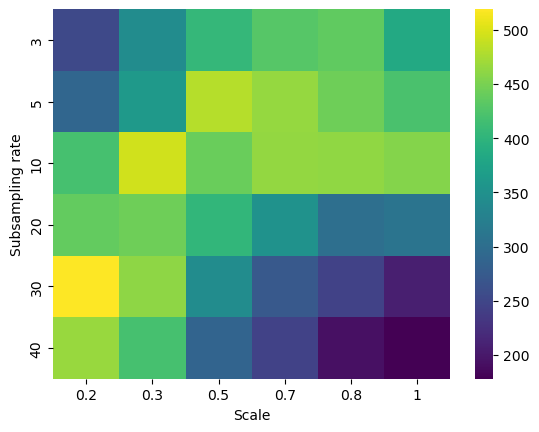

In [44]:
# Plot heatmap
sns.heatmap(M, cmap='viridis')
plt.xticks(ticks=np.arange(len(scaling_values)) + 0.5, labels=scaling_values)  # Adjust 0.5 offset if needed
plt.yticks(ticks=np.arange(len(subsampling_rate_values)) + 0.5, labels=subsampling_rate_values)  # Adjust 0.5 offset if needed
plt.xlabel('Scale')
plt.ylabel('Subsampling rate')
plt.show()

### Gridsearch for Euler - Adjusted 

In [61]:
subsampling_rate_values = [1, 2, 3, 5 ,7, 10 ]
scaling_values = [ 0.3, 0.5, 0.7, 0.8, 0.9, 1 ]
# initialise the LinkFactory
my_posterior_coarse = tda.Posterior(x_distribution, y_distr_coarse, coarse_model)
my_posterior_fine = tda.Posterior(x_distribution, y_distr_fine, model_lf)
my_posteriors = [my_posterior_coarse, my_posterior_fine]

In [62]:
M = np.zeros((len(subsampling_rate_values), len(scaling_values)))


for index1, ssr in enumerate(subsampling_rate_values):
    for index2, scale in enumerate(scaling_values): 
        # Adaptive Metropolis
        my_proposal = tda.GaussianRandomWalk(C=covariance_matrix, scaling= scale)
        # Initialize a list to hold the Effective sample sizes for each initial guess
        ESS_values = []
        times = []
        # Iterate over each initial guess to set up and run the Markov chain sampler
        for index, initial_guess in enumerate(initial_guesses[0:2]):
            start = timeit.default_timer()
            samples = tda.sample(my_posteriors, my_proposal, 
                         iterations=4000, n_chains=1,
                           initial_parameters=initial_guess, 
                           subsampling_rate = ssr)
                           #adaptive_error_model='state-independent')
            end = timeit.default_timer()
            times.append(end-start)
            idata = tda.to_inference_data(samples, level='fine', parameter_names= ['Overetch', 'Offset', 'Thickness'])
            # Remove the burnin and sub-sample
            idata = idata.sel(draw=slice(250, None, 5), groups="posterior")
            ess = az.ess(idata)
            ESS_values.append((ess['Overetch'].values + ess['Offset'].values + ess['Thickness'].values)/3)
            if(index==1):
                print('sampled with params: ', ssr, scale, '   done ', index2+1 + index1*len(scaling_values), '/', len(scaling_values)*len(subsampling_rate_values))

        # Add the mean of the different sample sizes to the matrix
        M[index1, index2] = np.mean(times)/np.mean(ESS_values)

Sampling chain 1/1


Running chain, α_c = 0.680, α_f = 0.65: 100%|██████████| 4000/4000 [00:03<00:00, 1126.06it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.650, α_f = 0.42: 100%|██████████| 4000/4000 [00:03<00:00, 1223.39it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  1 0.3    done  1 / 36
Sampling chain 1/1


Running chain, α_c = 0.500, α_f = 0.39: 100%|██████████| 4000/4000 [00:03<00:00, 1157.78it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.500, α_f = 0.30: 100%|██████████| 4000/4000 [00:03<00:00, 1093.15it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  1 0.5    done  2 / 36
Sampling chain 1/1


Running chain, α_c = 0.360, α_f = 0.32: 100%|██████████| 4000/4000 [00:03<00:00, 1282.05it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.280, α_f = 0.21: 100%|██████████| 4000/4000 [00:03<00:00, 1273.03it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  1 0.7    done  3 / 36
Sampling chain 1/1


Running chain, α_c = 0.310, α_f = 0.23: 100%|██████████| 4000/4000 [00:03<00:00, 1232.40it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.280, α_f = 0.21: 100%|██████████| 4000/4000 [00:03<00:00, 1262.79it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  1 0.8    done  4 / 36
Sampling chain 1/1


Running chain, α_c = 0.170, α_f = 0.11: 100%|██████████| 4000/4000 [00:03<00:00, 1293.70it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.210, α_f = 0.15: 100%|██████████| 4000/4000 [00:03<00:00, 1323.03it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  1 0.9    done  5 / 36
Sampling chain 1/1


Running chain, α_c = 0.270, α_f = 0.16: 100%|██████████| 4000/4000 [00:03<00:00, 1327.16it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.240, α_f = 0.18: 100%|██████████| 4000/4000 [00:03<00:00, 1196.07it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  1 1    done  6 / 36
Sampling chain 1/1


Running chain, α_c = 0.655, α_f = 0.62: 100%|██████████| 4000/4000 [00:03<00:00, 1069.38it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.775, α_f = 0.67: 100%|██████████| 4000/4000 [00:03<00:00, 1063.18it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  2 0.3    done  7 / 36
Sampling chain 1/1


Running chain, α_c = 0.595, α_f = 0.48: 100%|██████████| 4000/4000 [00:03<00:00, 1107.99it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.615, α_f = 0.63: 100%|██████████| 4000/4000 [00:03<00:00, 1030.16it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  2 0.5    done  8 / 36
Sampling chain 1/1


Running chain, α_c = 0.340, α_f = 0.24: 100%|██████████| 4000/4000 [00:04<00:00, 957.13it/s] 
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.440, α_f = 0.43: 100%|██████████| 4000/4000 [00:04<00:00, 977.22it/s] 
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  2 0.7    done  9 / 36
Sampling chain 1/1


Running chain, α_c = 0.295, α_f = 0.21: 100%|██████████| 4000/4000 [00:03<00:00, 1058.44it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.360, α_f = 0.26: 100%|██████████| 4000/4000 [00:03<00:00, 1143.30it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  2 0.8    done  10 / 36
Sampling chain 1/1


Running chain, α_c = 0.355, α_f = 0.15: 100%|██████████| 4000/4000 [00:03<00:00, 1091.23it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.280, α_f = 0.25: 100%|██████████| 4000/4000 [00:03<00:00, 1132.01it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  2 0.9    done  11 / 36
Sampling chain 1/1


Running chain, α_c = 0.260, α_f = 0.24: 100%|██████████| 4000/4000 [00:03<00:00, 1164.16it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.310, α_f = 0.27: 100%|██████████| 4000/4000 [00:03<00:00, 1125.98it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  2 1    done  12 / 36
Sampling chain 1/1


Running chain, α_c = 0.713, α_f = 0.62: 100%|██████████| 4000/4000 [00:03<00:00, 1021.22it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.650, α_f = 0.52: 100%|██████████| 4000/4000 [00:04<00:00, 995.77it/s] 
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  3 0.3    done  13 / 36
Sampling chain 1/1


Running chain, α_c = 0.510, α_f = 0.42: 100%|██████████| 4000/4000 [00:04<00:00, 867.08it/s] 
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.530, α_f = 0.51: 100%|██████████| 4000/4000 [00:04<00:00, 892.46it/s] 
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  3 0.5    done  14 / 36
Sampling chain 1/1


Running chain, α_c = 0.437, α_f = 0.46: 100%|██████████| 4000/4000 [00:04<00:00, 874.01it/s] 
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.400, α_f = 0.40: 100%|██████████| 4000/4000 [00:04<00:00, 924.25it/s] 
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  3 0.7    done  15 / 36
Sampling chain 1/1


Running chain, α_c = 0.380, α_f = 0.34: 100%|██████████| 4000/4000 [00:04<00:00, 897.10it/s] 
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.407, α_f = 0.35: 100%|██████████| 4000/4000 [00:04<00:00, 894.11it/s] 
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  3 0.8    done  16 / 36
Sampling chain 1/1


Running chain, α_c = 0.313, α_f = 0.22: 100%|██████████| 4000/4000 [00:04<00:00, 890.80it/s] 
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.363, α_f = 0.25: 100%|██████████| 4000/4000 [00:04<00:00, 890.97it/s] 
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  3 0.9    done  17 / 36
Sampling chain 1/1


Running chain, α_c = 0.267, α_f = 0.19: 100%|██████████| 4000/4000 [00:04<00:00, 902.13it/s] 
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.287, α_f = 0.23: 100%|██████████| 4000/4000 [00:04<00:00, 904.03it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  3 1    done  18 / 36
Sampling chain 1/1


Running chain, α_c = 0.680, α_f = 0.65: 100%|██████████| 4000/4000 [00:05<00:00, 772.43it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.658, α_f = 0.60: 100%|██████████| 4000/4000 [00:05<00:00, 743.09it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  5 0.3    done  19 / 36
Sampling chain 1/1


Running chain, α_c = 0.550, α_f = 0.47: 100%|██████████| 4000/4000 [00:05<00:00, 788.41it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.542, α_f = 0.48: 100%|██████████| 4000/4000 [00:05<00:00, 763.33it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  5 0.5    done  20 / 36
Sampling chain 1/1


Running chain, α_c = 0.432, α_f = 0.24: 100%|██████████| 4000/4000 [00:05<00:00, 771.53it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.420, α_f = 0.42: 100%|██████████| 4000/4000 [00:05<00:00, 741.73it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  5 0.7    done  21 / 36
Sampling chain 1/1


Running chain, α_c = 0.358, α_f = 0.34: 100%|██████████| 4000/4000 [00:05<00:00, 768.65it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.388, α_f = 0.34: 100%|██████████| 4000/4000 [00:05<00:00, 773.46it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  5 0.8    done  22 / 36
Sampling chain 1/1


Running chain, α_c = 0.322, α_f = 0.27: 100%|██████████| 4000/4000 [00:04<00:00, 811.14it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.356, α_f = 0.28: 100%|██████████| 4000/4000 [00:05<00:00, 752.31it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  5 0.9    done  23 / 36
Sampling chain 1/1


Running chain, α_c = 0.342, α_f = 0.34: 100%|██████████| 4000/4000 [00:05<00:00, 786.11it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.324, α_f = 0.31: 100%|██████████| 4000/4000 [00:05<00:00, 759.94it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  5 1    done  24 / 36
Sampling chain 1/1


Running chain, α_c = 0.677, α_f = 0.53: 100%|██████████| 4000/4000 [00:05<00:00, 671.46it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.733, α_f = 0.59: 100%|██████████| 4000/4000 [00:06<00:00, 657.90it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  7 0.3    done  25 / 36
Sampling chain 1/1


Running chain, α_c = 0.557, α_f = 0.44: 100%|██████████| 4000/4000 [00:05<00:00, 695.52it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.563, α_f = 0.41: 100%|██████████| 4000/4000 [00:05<00:00, 676.25it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  7 0.5    done  26 / 36
Sampling chain 1/1


Running chain, α_c = 0.423, α_f = 0.35: 100%|██████████| 4000/4000 [00:06<00:00, 661.32it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.463, α_f = 0.28: 100%|██████████| 4000/4000 [00:05<00:00, 677.21it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  7 0.7    done  27 / 36
Sampling chain 1/1


Running chain, α_c = 0.354, α_f = 0.29: 100%|██████████| 4000/4000 [00:05<00:00, 668.80it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.346, α_f = 0.35: 100%|██████████| 4000/4000 [00:05<00:00, 705.14it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  7 0.8    done  28 / 36
Sampling chain 1/1


Running chain, α_c = 0.339, α_f = 0.26: 100%|██████████| 4000/4000 [00:05<00:00, 670.96it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.369, α_f = 0.33: 100%|██████████| 4000/4000 [00:05<00:00, 680.87it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  7 0.9    done  29 / 36
Sampling chain 1/1


Running chain, α_c = 0.320, α_f = 0.24: 100%|██████████| 4000/4000 [00:05<00:00, 690.09it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.301, α_f = 0.25: 100%|██████████| 4000/4000 [00:05<00:00, 675.37it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  7 1    done  30 / 36
Sampling chain 1/1


Running chain, α_c = 0.674, α_f = 0.31: 100%|██████████| 4000/4000 [00:06<00:00, 577.98it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.703, α_f = 0.41: 100%|██████████| 4000/4000 [00:06<00:00, 573.96it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  10 0.3    done  31 / 36
Sampling chain 1/1


Running chain, α_c = 0.563, α_f = 0.42: 100%|██████████| 4000/4000 [00:06<00:00, 575.71it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.551, α_f = 0.38: 100%|██████████| 4000/4000 [00:06<00:00, 593.04it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  10 0.5    done  32 / 36
Sampling chain 1/1


Running chain, α_c = 0.441, α_f = 0.36: 100%|██████████| 4000/4000 [00:06<00:00, 602.50it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.407, α_f = 0.32: 100%|██████████| 4000/4000 [00:06<00:00, 597.57it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  10 0.7    done  33 / 36
Sampling chain 1/1


Running chain, α_c = 0.418, α_f = 0.20: 100%|██████████| 4000/4000 [00:06<00:00, 603.52it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.402, α_f = 0.39: 100%|██████████| 4000/4000 [00:06<00:00, 600.76it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  10 0.8    done  34 / 36
Sampling chain 1/1


Running chain, α_c = 0.365, α_f = 0.29: 100%|██████████| 4000/4000 [00:06<00:00, 591.83it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.365, α_f = 0.35: 100%|██████████| 4000/4000 [00:06<00:00, 635.38it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  10 0.9    done  35 / 36
Sampling chain 1/1


Running chain, α_c = 0.320, α_f = 0.28: 100%|██████████| 4000/4000 [00:07<00:00, 556.69it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.312, α_f = 0.20: 100%|██████████| 4000/4000 [00:06<00:00, 585.76it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  10 1    done  36 / 36


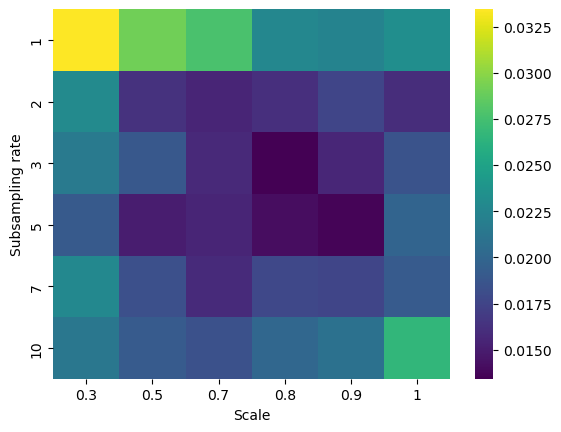

In [67]:
# Plot heatmap
sns.heatmap(M, cmap='viridis')
plt.xticks(ticks=np.arange(len(scaling_values)) + 0.5, labels=scaling_values)  # Adjust 0.5 offset if needed
plt.yticks(ticks=np.arange(len(subsampling_rate_values)) + 0.5, labels=subsampling_rate_values)  # Adjust 0.5 offset if needed
plt.xlabel('Scale')
plt.ylabel('Subsampling rate')
plt.show()

In [66]:
M = 1/M

### Compare distribution of Time / ESS

#### Compute Time/ESS performances for HIGH FIDELITY and MDA (Euler-Adjusted and High Fidelity)

RANDOMLY CHOOSE 20 SAMPLES TO EVALUATE TIME/ESS FOR THE DIFFERENT MODELS 

In [17]:
np.random.seed(1008)
random_samples = np.random.randint(0, 160, 20)
random_samples

array([ 24, 105, 145,  83,  20, 128, 103,  37,  49,  68, 133, 137,   5,
        86, 146,   2,  11, 131, 135,  83])

USE ONLY THE FINE MODEL 

In [55]:
n = 20
print('The extracted samples are: ', random_samples)

Times_fine = []
Time_ESS_fine = []
ESS_fine = []
i = 1
for s in random_samples:
    # Select a true sample for testing
    x_true, y_true = X_values[s], y_values[s]
    print(x_true)
    # Generate observed data by adding Gaussian noise to the true data
    y_observed = y_true + np.random.normal(scale=np.sqrt(noise),size=y_true.shape[0]) 
    # set the likelihood
    y_distribution = tda.GaussianLogLike(y_observed, cov_likelihood) 
    
    # Perform least squares optimization given the observed data, forward model,
    # start point, and parameter bounds
    init_guess, cov_matrix = least_squares_optimization(
        y_observed=y_observed, 
        forward_model=fine_model , 
        start_point=np.array([0.2, 0.25, 30.0]), 
        bounds=MCMC_SETTINGS['bounds']
    )
    # initialise the LinkFactory
    my_posterior = tda.Posterior(x_distribution, y_distribution, fine_model)
    # random walk Metropolis
    my_proposal = tda.GaussianRandomWalk(C=cov_matrix, scaling= 0.8) 

    # Perform the MH Algorithm 
    start = timeit.default_timer()
    samples = tda.sample(my_posterior, my_proposal, iterations=MCMC_SETTINGS['N'], n_chains=1, initial_parameters=init_guess)
    end = timeit.default_timer()
    idata = tda.to_inference_data(samples, level='fine', parameter_names= ['Overetch', 'Offset', 'Thickness'])
    ess = az.ess(idata)
    t = end-start
    Times_fine.append(t)
    e = (ess['Overetch'].values + ess['Offset'].values + ess['Thickness'].values)/3
    ESS_fine.append(e)
    Time_ESS_fine.append(t/e)
    print('Done ',i,'/20 iterations')
    print('Time/ESS =', t/e )
    i = i+1

print('Times of the fine model:\n', Times_fine)
print('\nEffective Sample Sizes of fine model:\n ', ESS_fine)
print('Time/ESS: \n',Time_ESS_fine)

The extracted samples are:  [ 24 105 145  83  20 128 103  37  49  68 133 137   5  86 146   2  11 131
 135  83]
[ 0.462475 -0.221586 30.575526]
Sampling chain 1/1


Running chain, α = 0.21: 100%|██████████| 6000/6000 [00:22<00:00, 268.05it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Done  1 /20 iterations
Time/ESS = 0.05622362273086651
[ 0.128917  0.285462 30.259288]
Sampling chain 1/1


Running chain, α = 0.22: 100%|██████████| 6000/6000 [00:22<00:00, 268.40it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Done  2 /20 iterations
Time/ESS = 0.1705906369758537
[ 0.418297  0.210256 29.835135]
Sampling chain 1/1


Running chain, α = 0.16: 100%|██████████| 6000/6000 [00:22<00:00, 270.05it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Done  3 /20 iterations
Time/ESS = 0.05906427593672786
[ 0.12017   0.177757 29.019343]
Sampling chain 1/1


Running chain, α = 0.31: 100%|██████████| 6000/6000 [00:22<00:00, 268.39it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Done  4 /20 iterations
Time/ESS = 0.05840638676091852
[ 0.211305  0.183238 29.364769]
Sampling chain 1/1


Running chain, α = 0.29: 100%|██████████| 6000/6000 [00:22<00:00, 263.65it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Done  5 /20 iterations
Time/ESS = 0.03896077779530761
[ 0.164689 -0.39078  29.330976]
Sampling chain 1/1


Running chain, α = 0.23: 100%|██████████| 6000/6000 [00:22<00:00, 272.02it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Done  6 /20 iterations
Time/ESS = 0.047980367010086934
[ 0.115936  0.047662 30.639655]
Sampling chain 1/1


Running chain, α = 0.29: 100%|██████████| 6000/6000 [00:21<00:00, 273.07it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Done  7 /20 iterations
Time/ESS = 0.05062860950009086
[ 0.46283   0.063884 30.828432]
Sampling chain 1/1


Running chain, α = 0.31: 100%|██████████| 6000/6000 [00:22<00:00, 269.43it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Done  8 /20 iterations
Time/ESS = 0.05656738653574766
[ 0.254074 -0.463495 29.71306 ]
Sampling chain 1/1


Running chain, α = 0.34: 100%|██████████| 6000/6000 [00:22<00:00, 271.53it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Done  9 /20 iterations
Time/ESS = 0.048131406237192254
[ 0.16726  -0.125753 29.617864]
Sampling chain 1/1


Running chain, α = 0.23: 100%|██████████| 6000/6000 [00:22<00:00, 267.46it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Done  10 /20 iterations
Time/ESS = 0.05174869176412651
[ 0.32954  -0.167992 30.299452]
Sampling chain 1/1


Running chain, α = 0.29: 100%|██████████| 6000/6000 [00:23<00:00, 259.17it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Done  11 /20 iterations
Time/ESS = 0.04873639530662871
[ 0.423757 -0.347213 30.887732]
Sampling chain 1/1


Running chain, α = 0.25: 100%|██████████| 6000/6000 [00:21<00:00, 272.97it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Done  12 /20 iterations
Time/ESS = 0.05609483108327778
[ 0.230536 -0.068871 30.351452]
Sampling chain 1/1


Running chain, α = 0.30: 100%|██████████| 6000/6000 [00:20<00:00, 295.30it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Done  13 /20 iterations
Time/ESS = 0.04312936683919612
[ 0.23733   0.428998 29.895089]
Sampling chain 1/1


Running chain, α = 0.24: 100%|██████████| 6000/6000 [00:20<00:00, 291.55it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Done  14 /20 iterations
Time/ESS = 0.06831802224328429
[ 0.208638 -0.382417 30.991585]
Sampling chain 1/1


Running chain, α = 0.16: 100%|██████████| 6000/6000 [00:21<00:00, 282.79it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Done  15 /20 iterations
Time/ESS = 0.05984651651288328
[ 0.122269  0.396304 29.130577]
Sampling chain 1/1


Running chain, α = 0.29: 100%|██████████| 6000/6000 [00:21<00:00, 273.43it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Done  16 /20 iterations
Time/ESS = 0.0831972336872892
[ 4.5057900e-01 -4.4200000e-04  2.9471304e+01]
Sampling chain 1/1


Running chain, α = 0.33: 100%|██████████| 6000/6000 [00:20<00:00, 292.34it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Done  17 /20 iterations
Time/ESS = 0.05138868876892695
[ 0.272002  0.083286 30.390501]
Sampling chain 1/1


Running chain, α = 0.27: 100%|██████████| 6000/6000 [00:20<00:00, 287.90it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Done  18 /20 iterations
Time/ESS = 0.04719863060251584
[ 0.258854  0.381479 29.366104]
Sampling chain 1/1


Running chain, α = 0.15: 100%|██████████| 6000/6000 [00:20<00:00, 289.80it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Done  19 /20 iterations
Time/ESS = 0.07428245649077178
[ 0.12017   0.177757 29.019343]
Sampling chain 1/1


Running chain, α = 0.31: 100%|██████████| 6000/6000 [00:22<00:00, 262.68it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Done  20 /20 iterations
Time/ESS = 0.06916250109781762
Times of the fine model:
 [22.390058874996612, 22.359846707986435, 22.22165341701475, 22.358996750001097, 22.761691916995915, 22.06125745800091, 21.97618566598976, 22.273933542019222, 22.101074125006562, 22.437955959001556, 23.15877808301593, 21.985296041995753, 20.322156207985245, 20.584135665994836, 21.221305459010182, 21.948363750008866, 20.52875691698864, 20.845005084003787, 20.70801683299942, 22.84961566698621]

Effective Sample Sizes of fine model:
  [398.23223384544684, 131.07311810525314, 376.22832185091914, 382.817667552792, 584.2206753823407, 459.7975970747152, 434.06654622719435, 393.75928262026474, 459.1819739504837, 433.59465126722506, 475.1844681435862, 391.9308716583284, 471.1906920348388, 301.2987640756575, 354.5955002149846, 263.81122036467565, 399.4800686450226, 441.64427691876045, 278.7739906739892, 330.375786073289]
Time/ESS: 
 [0.05622362273086651, 0.1705906369758537, 0.05906427593672786, 0.05840638676091852, 0

MDA

In [56]:
n = 25
print('The extracted samples are: ', random_samples)

Times_mda = []
Time_ESS_mda = []
ESS_mda = []
i = 1
for s in random_samples:
    # Select a true sample for testing
    x_true, y_true = X_values[s], y_values[s]
    print(x_true)
    # Generate observed data by adding Gaussian noise to the true data
    y_observed = y_true + np.random.normal(scale=np.sqrt(noise),size=y_true.shape[0]) 
    # set the likelihood
    y_distr_fine= tda.GaussianLogLike(y_observed, cov_likelihood) 
    y_distr_coarse = tda.GaussianLogLike(y_observed, cov_likelihood*10) 
    
    # Perform least squares optimization given the observed data, forward model,
    # start point, and parameter bounds
    start = timeit.default_timer()
    init_guess, cov_matrix = least_squares_optimization(
        y_observed=y_observed, 
        forward_model=model_lf , 
        start_point=np.array([0.2, 0.25, 30.0]), 
        bounds=MCMC_SETTINGS['bounds']
    )
    # initialise the LinkFactory
    my_posterior_coarse = tda.Posterior(x_distribution, y_distr_coarse,model_lf)
    my_posterior_fine = tda.Posterior(x_distribution, y_distr_fine, fine_model)
    my_posteriors = [my_posterior_coarse, my_posterior_fine]    
    
    # random walk Metropolis
    my_proposal = tda.GaussianRandomWalk(C=cov_matrix, scaling= 0.2) 

    # Perform the MH Algorithm 
    samples = tda.sample(my_posteriors, my_proposal, iterations=2100, n_chains=1, initial_parameters=init_guess,subsampling_rate = 30)
    end = timeit.default_timer()
    idata = tda.to_inference_data(samples, level='fine', parameter_names= ['Overetch', 'Offset', 'Thickness'])
    ess = az.ess(idata)
    t = end-start
    Times_mda.append(t)
    e = (ess['Overetch'].values + ess['Offset'].values + ess['Thickness'].values)/3
    ESS_mda.append(e)
    Time_ESS_mda.append(t/e)
    print('Done ',i,'/25 iterations')
    print('Time/ESS =', t/e )
    i = i+1
    

print('Times of the fine model:\n', Times_mda)
print('\nEffective Sample Sizes of fine model:\n ', ESS_mda)
print('Time/ESS: \n',Time_ESS_mda)

The extracted samples are:  [ 24 105 145  83  20 128 103  37  49  68 133 137   5  86 146   2  11 131
 135  83]
[ 0.462475 -0.221586 30.575526]
Sampling chain 1/1


Running chain, α_c = 0.780, α_f = 0.48: 100%|██████████| 2100/2100 [00:12<00:00, 166.34it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Done  1 /25 iterations
Time/ESS = 0.03198384743584913
[ 0.128917  0.285462 30.259288]
Sampling chain 1/1


Running chain, α_c = 0.670, α_f = 0.49: 100%|██████████| 2100/2100 [00:12<00:00, 174.57it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Done  2 /25 iterations
Time/ESS = 0.04920274363100383
[ 0.418297  0.210256 29.835135]
Sampling chain 1/1


Running chain, α_c = 0.808, α_f = 0.38: 100%|██████████| 2100/2100 [00:12<00:00, 174.73it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Done  3 /25 iterations
Time/ESS = 0.031224601600688972
[ 0.12017   0.177757 29.019343]
Sampling chain 1/1


Running chain, α_c = 0.811, α_f = 0.34: 100%|██████████| 2100/2100 [00:12<00:00, 172.99it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Done  4 /25 iterations
Time/ESS = 0.0370538039589103
[ 0.211305  0.183238 29.364769]
Sampling chain 1/1


Running chain, α_c = 0.808, α_f = 0.32: 100%|██████████| 2100/2100 [00:11<00:00, 176.19it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Done  5 /25 iterations
Time/ESS = 0.04596156083656524
[ 0.164689 -0.39078  29.330976]
Sampling chain 1/1


Running chain, α_c = 0.829, α_f = 0.44: 100%|██████████| 2100/2100 [00:12<00:00, 170.09it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Done  6 /25 iterations
Time/ESS = 0.02879787243210054
[ 0.115936  0.047662 30.639655]
Sampling chain 1/1


Running chain, α_c = 0.840, α_f = 0.36: 100%|██████████| 2100/2100 [00:12<00:00, 174.02it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Done  7 /25 iterations
Time/ESS = 0.035506756761135384
[ 0.46283   0.063884 30.828432]
Sampling chain 1/1


Running chain, α_c = 0.825, α_f = 0.46: 100%|██████████| 2100/2100 [00:12<00:00, 173.39it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Done  8 /25 iterations
Time/ESS = 0.028296588444838823
[ 0.254074 -0.463495 29.71306 ]
Sampling chain 1/1


Running chain, α_c = 0.795, α_f = 0.39: 100%|██████████| 2100/2100 [00:12<00:00, 171.48it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Done  9 /25 iterations
Time/ESS = 0.041293670585148386
[ 0.16726  -0.125753 29.617864]
Sampling chain 1/1


Running chain, α_c = 0.868, α_f = 0.51: 100%|██████████| 2100/2100 [00:12<00:00, 171.41it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Done  10 /25 iterations
Time/ESS = 0.024924837857156427
[ 0.32954  -0.167992 30.299452]
Sampling chain 1/1


Running chain, α_c = 0.813, α_f = 0.42: 100%|██████████| 2100/2100 [00:11<00:00, 175.69it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Done  11 /25 iterations
Time/ESS = 0.03476909981145764
[ 0.423757 -0.347213 30.887732]
Sampling chain 1/1


Running chain, α_c = 0.798, α_f = 0.47: 100%|██████████| 2100/2100 [00:12<00:00, 170.95it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Done  12 /25 iterations
Time/ESS = 0.03152632431643342
[ 0.230536 -0.068871 30.351452]
Sampling chain 1/1


Running chain, α_c = 0.846, α_f = 0.40: 100%|██████████| 2100/2100 [00:12<00:00, 173.73it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Done  13 /25 iterations
Time/ESS = 0.02470428521990619
[ 0.23733   0.428998 29.895089]
Sampling chain 1/1


Running chain, α_c = 0.746, α_f = 0.49: 100%|██████████| 2100/2100 [00:11<00:00, 175.39it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Done  14 /25 iterations
Time/ESS = 0.024357323653962645
[ 0.208638 -0.382417 30.991585]
Sampling chain 1/1


Running chain, α_c = 0.810, α_f = 0.41: 100%|██████████| 2100/2100 [00:11<00:00, 175.16it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Done  15 /25 iterations
Time/ESS = 0.03504519185203546
[ 0.122269  0.396304 29.130577]
Sampling chain 1/1


Running chain, α_c = 0.900, α_f = 0.36: 100%|██████████| 2100/2100 [00:12<00:00, 173.86it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Done  16 /25 iterations
Time/ESS = 0.03544960928833679
[ 4.5057900e-01 -4.4200000e-04  2.9471304e+01]
Sampling chain 1/1


Running chain, α_c = 0.811, α_f = 0.36: 100%|██████████| 2100/2100 [00:12<00:00, 169.03it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Done  17 /25 iterations
Time/ESS = 0.026051474678162833
[ 0.272002  0.083286 30.390501]
Sampling chain 1/1


Running chain, α_c = 0.840, α_f = 0.45: 100%|██████████| 2100/2100 [00:12<00:00, 173.83it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Done  18 /25 iterations
Time/ESS = 0.028301855369207103
[ 0.258854  0.381479 29.366104]
Sampling chain 1/1


Running chain, α_c = 0.380, α_f = 0.42: 100%|██████████| 2100/2100 [00:12<00:00, 174.89it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Done  19 /25 iterations
Time/ESS = 0.08595242312423806
[ 0.12017   0.177757 29.019343]
Sampling chain 1/1


Running chain, α_c = 0.860, α_f = 0.38: 100%|██████████| 2100/2100 [00:11<00:00, 175.26it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Done  20 /25 iterations
Time/ESS = 0.03963712330170385
Times of the fine model:
 [12.64564733300358, 12.079870041023241, 12.061258250003448, 12.187948458973551, 11.950384125026176, 12.384107667021453, 12.105026000004727, 12.161779292015126, 12.286680207995232, 12.368526167003438, 11.988909915991826, 12.325612166983774, 12.130558874981944, 12.013203457987402, 12.02132341597462, 12.110317833023146, 12.470821167022223, 12.142804958013585, 12.051565917005064, 12.00744679098716]

Effective Sample Sizes of fine model:
  [395.3760521890713, 245.5121228933141, 386.2742078905281, 328.9257014607463, 260.00823095457, 430.03550683199364, 340.92175980585534, 429.7966631462735, 297.5439100929487, 496.23296399708306, 344.81507951037196, 390.9625506376879, 491.03055469936834, 493.2070382056527, 343.02347285556124, 341.62062928596333, 478.6992414473818, 429.0462515480579, 140.21205544822615, 302.9343653319817]
Time/ESS: 
 [0.03198384743584913, 0.04920274363100383, 0.031224601600688972, 0.03705380395891

Comparison of the High Fidelity model with MDA (HF - LF_adjusted)

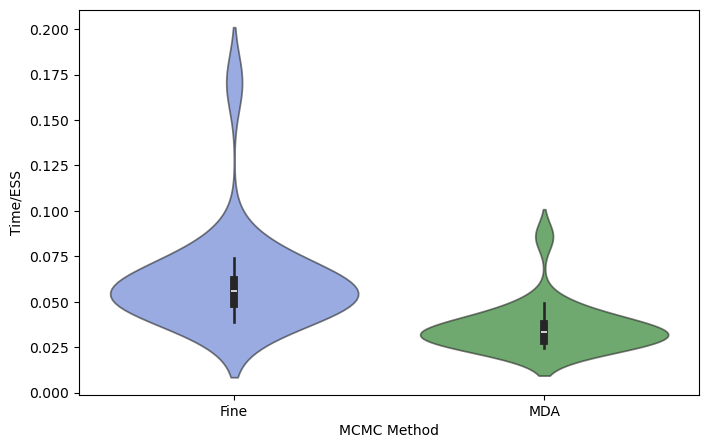

In [57]:
data = [Time_ESS_fine, Time_ESS_mda]

# Labels for the datasets
labels = ['Fine', 'MDA']

# Create the violin plot
plt.figure(figsize=(8, 5))
sns.violinplot(data=data, palette=['royalblue', 'green'], alpha=0.6)
plt.xticks([0, 1], labels)
plt.xlabel('MCMC Method')
plt.ylabel('Time/ESS')
#plt.title('Violin Plot of Time/ESS for Fine model and MDA')
plt.show()

In [58]:
np.mean(Time_ESS_fine)/np.mean(Time_ESS_mda)

1.721647536648506

This result is expected since the MDA using the adjusted model, in this context with increased noise, is practically as precise ad the high fidelity model despite beeing significantly faster.   \
We will also analyze the potential benefits of this technique in a more challenging setting, using as lower fidelity model the euler approximation and as high fidelity the Euler Adjusted model.

#### Compute Time/ESS performances for Euler Adjusted and MDA (Euler-Adjusted and Euler)

In [69]:
n = 30 
np.random.seed(1008)
random_samples = np.random.randint(0, 160, n)
random_samples

array([ 24, 105, 145,  83,  20, 128, 103,  37,  49,  68, 133, 137,   5,
        86, 146,   2,  11, 131, 135,  83,  37, 145,   2,  47, 147, 122,
       111,  18, 107,  63])

MDA Euler - Euler Adjusted 

In [75]:
print('The extracted samples are: ', random_samples)

Times_mda = []
Time_ESS_mda = []
ESS_mda = []
i = 1
for s in random_samples:
    # Select a true sample for testing
    x_true, y_true = X_values[s], y_values[s]
    print(x_true)
    # Generate observed data by adding Gaussian noise to the true data
    y_observed = y_true + np.random.normal(scale=np.sqrt(noise),size=y_true.shape[0]) 
    # set the likelihood
    y_distr_fine= tda.GaussianLogLike(y_observed, cov_likelihood) 
    y_distr_coarse = tda.GaussianLogLike(y_observed, cov_likelihood*10) 
    
    # Perform least squares optimization given the observed data, forward model,
    # start point, and parameter bounds
    start = timeit.default_timer()
    init_guess, cov_matrix = least_squares_optimization(
        y_observed=y_observed, 
        forward_model=model_lf , 
        start_point=np.array([0.2, 0.25, 30.0]), 
        bounds=MCMC_SETTINGS['bounds']
    )
    # initialise the LinkFactory
    my_posterior_coarse = tda.Posterior(x_distribution, y_distr_coarse,coarse_model) # Euler model
    my_posterior_fine = tda.Posterior(x_distribution, y_distr_fine, model_lf)        # Euler model with linear correction
    my_posteriors = [my_posterior_coarse, my_posterior_fine]    
    
    # random walk Metropolis
    my_proposal = tda.GaussianRandomWalk(C=cov_matrix, scaling= 0.8) 

    # Perform the MH Algorithm 
    samples = tda.sample(my_posteriors, my_proposal, iterations=2100, n_chains=1, initial_parameters=init_guess,subsampling_rate = 3)
    end = timeit.default_timer()
    idata = tda.to_inference_data(samples, level='fine', parameter_names= ['Overetch', 'Offset', 'Thickness'])
    ess = az.ess(idata)
    t = end-start
    Times_mda.append(t)
    e = (ess['Overetch'].values + ess['Offset'].values + ess['Thickness'].values)/3
    ESS_mda.append(e)
    Time_ESS_mda.append(t/e)
    print('Time/ESS =', t/e )
    print('Done ',i,'/', n, ' iterations')
    i = i+1
    

print('Times of the fine model:\n', Times_mda)
print('\nEffective Sample Sizes of fine model:\n ', ESS_mda)
print('Time/ESS: \n',Time_ESS_mda)

The extracted samples are:  [ 24 105 145  83  20 128 103  37  49  68 133 137   5  86 146   2  11 131
 135  83  37 145   2  47 147 122 111  18 107  63]
[ 0.462475 -0.221586 30.575526]
Sampling chain 1/1


  0%|          | 0/2100 [00:00<?, ?it/s]

Running chain, α_c = 0.407, α_f = 0.38: 100%|██████████| 2100/2100 [00:02<00:00, 878.62it/s] 
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Time/ESS = 0.007018342310951892
Done  1 / 30  iterations
[ 0.128917  0.285462 30.259288]
Sampling chain 1/1


Running chain, α_c = 0.130, α_f = 0.18: 100%|██████████| 2100/2100 [00:02<00:00, 877.54it/s] 
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Time/ESS = 0.04640867412164325
Done  2 / 30  iterations
[ 0.418297  0.210256 29.835135]
Sampling chain 1/1


Running chain, α_c = 0.383, α_f = 0.38: 100%|██████████| 2100/2100 [00:02<00:00, 854.17it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Time/ESS = 0.008896359857463367
Done  3 / 30  iterations
[ 0.12017   0.177757 29.019343]
Sampling chain 1/1


Running chain, α_c = 0.400, α_f = 0.41: 100%|██████████| 2100/2100 [00:02<00:00, 807.11it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Time/ESS = 0.010676030529491422
Done  4 / 30  iterations
[ 0.211305  0.183238 29.364769]
Sampling chain 1/1


Running chain, α_c = 0.407, α_f = 0.45: 100%|██████████| 2100/2100 [00:02<00:00, 905.50it/s] 
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Time/ESS = 0.008644709194611288
Done  5 / 30  iterations
[ 0.164689 -0.39078  29.330976]
Sampling chain 1/1


Running chain, α_c = 0.383, α_f = 0.30: 100%|██████████| 2100/2100 [00:02<00:00, 959.61it/s] 
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Time/ESS = 0.00841601784375714
Done  6 / 30  iterations
[ 0.115936  0.047662 30.639655]
Sampling chain 1/1


Running chain, α_c = 0.387, α_f = 0.32: 100%|██████████| 2100/2100 [00:02<00:00, 1014.96it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Time/ESS = 0.008382001663298855
Done  7 / 30  iterations
[ 0.46283   0.063884 30.828432]
Sampling chain 1/1


Running chain, α_c = 0.377, α_f = 0.43: 100%|██████████| 2100/2100 [00:02<00:00, 949.45it/s] 
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Time/ESS = 0.007945827498183827
Done  8 / 30  iterations
[ 0.254074 -0.463495 29.71306 ]
Sampling chain 1/1


Running chain, α_c = 0.363, α_f = 0.33: 100%|██████████| 2100/2100 [00:02<00:00, 985.25it/s] 
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Time/ESS = 0.01016386202170224
Done  9 / 30  iterations
[ 0.16726  -0.125753 29.617864]
Sampling chain 1/1


Running chain, α_c = 0.530, α_f = 0.45: 100%|██████████| 2100/2100 [00:02<00:00, 975.11it/s] 
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Time/ESS = 0.006152493596312829
Done  10 / 30  iterations
[ 0.32954  -0.167992 30.299452]
Sampling chain 1/1


Running chain, α_c = 0.390, α_f = 0.33: 100%|██████████| 2100/2100 [00:02<00:00, 1033.69it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Time/ESS = 0.006791273894539712
Done  11 / 30  iterations
[ 0.423757 -0.347213 30.887732]
Sampling chain 1/1


Running chain, α_c = 0.327, α_f = 0.36: 100%|██████████| 2100/2100 [00:02<00:00, 962.48it/s] 
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Time/ESS = 0.007775065377783205
Done  12 / 30  iterations
[ 0.230536 -0.068871 30.351452]
Sampling chain 1/1


Running chain, α_c = 0.480, α_f = 0.47: 100%|██████████| 2100/2100 [00:02<00:00, 1008.36it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Time/ESS = 0.005776525338676511
Done  13 / 30  iterations
[ 0.23733   0.428998 29.895089]
Sampling chain 1/1


Running chain, α_c = 0.317, α_f = 0.27: 100%|██████████| 2100/2100 [00:02<00:00, 1014.70it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Time/ESS = 0.012222888005776707
Done  14 / 30  iterations
[ 0.208638 -0.382417 30.991585]
Sampling chain 1/1


Running chain, α_c = 0.453, α_f = 0.44: 100%|██████████| 2100/2100 [00:02<00:00, 957.26it/s] 
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Time/ESS = 0.007524992056693511
Done  15 / 30  iterations
[ 0.122269  0.396304 29.130577]
Sampling chain 1/1


Running chain, α_c = 0.470, α_f = 0.24: 100%|██████████| 2100/2100 [00:02<00:00, 956.03it/s] 
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Time/ESS = 0.011944303029565274
Done  16 / 30  iterations
[ 4.5057900e-01 -4.4200000e-04  2.9471304e+01]
Sampling chain 1/1


Running chain, α_c = 0.353, α_f = 0.27: 100%|██████████| 2100/2100 [00:02<00:00, 986.07it/s] 
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Time/ESS = 0.009667263962553215
Done  17 / 30  iterations
[ 0.272002  0.083286 30.390501]
Sampling chain 1/1


Running chain, α_c = 0.410, α_f = 0.38: 100%|██████████| 2100/2100 [00:02<00:00, 984.73it/s] 
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Time/ESS = 0.009248264665261532
Done  18 / 30  iterations
[ 0.258854  0.381479 29.366104]
Sampling chain 1/1


Running chain, α_c = 0.100, α_f = 0.12: 100%|██████████| 2100/2100 [00:02<00:00, 962.08it/s] 
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Time/ESS = 0.0661381676801159
Done  19 / 30  iterations
[ 0.12017   0.177757 29.019343]
Sampling chain 1/1


Running chain, α_c = 0.293, α_f = 0.23: 100%|██████████| 2100/2100 [00:02<00:00, 983.55it/s] 
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Time/ESS = 0.010257443644285704
Done  20 / 30  iterations
[ 0.46283   0.063884 30.828432]
Sampling chain 1/1


Running chain, α_c = 0.353, α_f = 0.20: 100%|██████████| 2100/2100 [00:02<00:00, 930.85it/s] 
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Time/ESS = 0.014491778316673937
Done  21 / 30  iterations
[ 0.418297  0.210256 29.835135]
Sampling chain 1/1


Running chain, α_c = 0.373, α_f = 0.29: 100%|██████████| 2100/2100 [00:01<00:00, 1079.66it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Time/ESS = 0.007305723750226746
Done  22 / 30  iterations
[ 0.122269  0.396304 29.130577]
Sampling chain 1/1


Running chain, α_c = 0.537, α_f = 0.25: 100%|██████████| 2100/2100 [00:02<00:00, 1040.86it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Time/ESS = 0.015460320134880568
Done  23 / 30  iterations
[ 0.426469  0.36583  29.324316]
Sampling chain 1/1


Running chain, α_c = 0.153, α_f = 0.14: 100%|██████████| 2100/2100 [00:02<00:00, 937.44it/s] 
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Time/ESS = 0.02093134476065648
Done  24 / 30  iterations
[ 0.311047 -0.348524 30.999168]
Sampling chain 1/1


Running chain, α_c = 0.403, α_f = 0.34: 100%|██████████| 2100/2100 [00:01<00:00, 1050.08it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Time/ESS = 0.008585108891380358
Done  25 / 30  iterations
[ 0.405649  0.241836 30.908042]
Sampling chain 1/1


Running chain, α_c = 0.330, α_f = 0.32: 100%|██████████| 2100/2100 [00:02<00:00, 926.32it/s] 
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Time/ESS = 0.008675368810858149
Done  26 / 30  iterations
[ 0.479667 -0.473952 29.349532]
Sampling chain 1/1


Running chain, α_c = 0.213, α_f = 0.20: 100%|██████████| 2100/2100 [00:02<00:00, 1039.36it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Time/ESS = 0.010473894842029883
Done  27 / 30  iterations
[ 0.119923  0.440009 30.8589  ]
Sampling chain 1/1


Running chain, α_c = 0.307, α_f = 0.29: 100%|██████████| 2100/2100 [00:02<00:00, 954.70it/s] 
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Time/ESS = 0.008715674751866034
Done  28 / 30  iterations
[ 0.126997  0.161484 30.377274]
Sampling chain 1/1


Running chain, α_c = 0.380, α_f = 0.42: 100%|██████████| 2100/2100 [00:02<00:00, 950.73it/s] 
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Time/ESS = 0.006256973280179788
Done  29 / 30  iterations
[ 0.368893  0.033376 29.525593]
Sampling chain 1/1


Running chain, α_c = 0.363, α_f = 0.33: 100%|██████████| 2100/2100 [00:02<00:00, 999.15it/s] 
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Time/ESS = 0.0071200317054718725
Done  30 / 30  iterations
Times of the fine model:
 [2.401992083992809, 2.4086686249938793, 2.46428883302724, 2.60765654098941, 2.331095041008666, 2.196091250050813, 2.0767230420024134, 2.218509958998766, 2.139965917041991, 2.1600514160236344, 2.0387347909854725, 2.189606333966367, 2.088050958001986, 2.080420124984812, 2.200516791024711, 2.20477666700026, 2.1399005420389585, 2.138261124957353, 2.1956050419830717, 2.1417177919647656, 2.264355166000314, 1.9512242499622516, 2.0239985829684883, 2.2479320419952273, 2.0070399579708464, 2.2775092500378378, 2.028489875025116, 2.2067315420135856, 2.2192079999949783, 2.10973795800237]

Effective Sample Sizes of fine model:
  [342.2449315765889, 51.90125920599329, 276.99967992637903, 244.25337992299953, 269.6556921153303, 260.9418481306853, 247.7597983660015, 279.20439494890235, 210.54653363777072, 351.0855204007277, 300.19917067763186, 281.61902538119347, 361.4717906665307, 170.20692032861436, 292.4277892183743, 

Only Euler Adjusted

In [71]:
print('The extracted samples are: ', random_samples)

Times_fine = []
Time_ESS_fine = []
ESS_fine = []
i = 1
for s in random_samples:
    # Select a true sample for testing
    x_true, y_true = X_values[s], y_values[s]
    print(x_true)
    # Generate observed data by adding Gaussian noise to the true data
    y_observed = y_true + np.random.normal(scale=np.sqrt(noise),size=y_true.shape[0]) 
    # set the likelihood
    y_distribution = tda.GaussianLogLike(y_observed, cov_likelihood) 
    
    # Perform least squares optimization given the observed data, forward model,
    # start point, and parameter bounds
    init_guess, cov_matrix = least_squares_optimization(
        y_observed=y_observed, 
        forward_model=model_lf , 
        start_point=np.array([0.2, 0.25, 30.0]), 
        bounds=MCMC_SETTINGS['bounds']
    )
    # initialise the LinkFactory
    my_posterior = tda.Posterior(x_distribution, y_distribution, model_lf)
    # random walk Metropolis
    my_proposal = tda.GaussianRandomWalk(C=cov_matrix, scaling= 0.8) 

    # Perform the MH Algorithm 
    start = timeit.default_timer()
    samples = tda.sample(my_posterior, my_proposal, iterations=MCMC_SETTINGS['N'], n_chains=1, initial_parameters=init_guess)
    end = timeit.default_timer()
    idata = tda.to_inference_data(samples, level='fine', parameter_names= ['Overetch', 'Offset', 'Thickness'])
    ess = az.ess(idata)
    t = end-start
    Times_fine.append(t)
    e = (ess['Overetch'].values + ess['Offset'].values + ess['Thickness'].values)/3
    ESS_fine.append(e)
    Time_ESS_fine.append(t/e)
    print('Time/ESS =', t/e )
    print('Done ',i,'/', n,' iterations')

    i = i+1

print('Times of the fine model:\n', Times_fine)
print('\nEffective Sample Sizes of fine model:\n ', ESS_fine)
print('Time/ESS: \n',Time_ESS_fine)

The extracted samples are:  [ 24 105 145  83  20 128 103  37  49  68 133 137   5  86 146   2  11 131
 135  83  37 145   2  47 147 122 111  18 107  63]
[ 0.462475 -0.221586 30.575526]
Sampling chain 1/1


Running chain, α = 0.29: 100%|██████████| 6000/6000 [00:05<00:00, 1165.06it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Time/ESS = 0.014824226530235705
Done  1 / 30  iterations
[ 0.128917  0.285462 30.259288]
Sampling chain 1/1


Running chain, α = 0.02: 100%|██████████| 6000/6000 [00:04<00:00, 1304.11it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Time/ESS = 0.04720168386119057
Done  2 / 30  iterations
[ 0.418297  0.210256 29.835135]
Sampling chain 1/1


Running chain, α = 0.25: 100%|██████████| 6000/6000 [00:04<00:00, 1265.88it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Time/ESS = 0.01007503893879969
Done  3 / 30  iterations
[ 0.12017   0.177757 29.019343]
Sampling chain 1/1


Running chain, α = 0.32: 100%|██████████| 6000/6000 [00:04<00:00, 1292.74it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Time/ESS = 0.007055711022419329
Done  4 / 30  iterations
[ 0.211305  0.183238 29.364769]
Sampling chain 1/1


Running chain, α = 0.19: 100%|██████████| 6000/6000 [00:04<00:00, 1283.81it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Time/ESS = 0.00764964402537937
Done  5 / 30  iterations
[ 0.164689 -0.39078  29.330976]
Sampling chain 1/1


Running chain, α = 0.22: 100%|██████████| 6000/6000 [00:04<00:00, 1328.83it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Time/ESS = 0.012364368113164636
Done  6 / 30  iterations
[ 0.115936  0.047662 30.639655]
Sampling chain 1/1


Running chain, α = 0.26: 100%|██████████| 6000/6000 [00:04<00:00, 1281.19it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Time/ESS = 0.007756652298090042
Done  7 / 30  iterations
[ 0.46283   0.063884 30.828432]
Sampling chain 1/1


Running chain, α = 0.21: 100%|██████████| 6000/6000 [00:04<00:00, 1291.44it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Time/ESS = 0.01165235372927851
Done  8 / 30  iterations
[ 0.254074 -0.463495 29.71306 ]
Sampling chain 1/1


Running chain, α = 0.25: 100%|██████████| 6000/6000 [00:04<00:00, 1328.57it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Time/ESS = 0.0106515996964215
Done  9 / 30  iterations
[ 0.16726  -0.125753 29.617864]
Sampling chain 1/1


Running chain, α = 0.24: 100%|██████████| 6000/6000 [00:04<00:00, 1323.67it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Time/ESS = 0.009712700826574489
Done  10 / 30  iterations
[ 0.32954  -0.167992 30.299452]
Sampling chain 1/1


Running chain, α = 0.22: 100%|██████████| 6000/6000 [00:04<00:00, 1249.59it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Time/ESS = 0.014544757349650888
Done  11 / 30  iterations
[ 0.423757 -0.347213 30.887732]
Sampling chain 1/1


Running chain, α = 0.19: 100%|██████████| 6000/6000 [00:04<00:00, 1319.54it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Time/ESS = 0.016359633781478408
Done  12 / 30  iterations
[ 0.230536 -0.068871 30.351452]
Sampling chain 1/1


Running chain, α = 0.24: 100%|██████████| 6000/6000 [00:04<00:00, 1240.40it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Time/ESS = 0.00972727139628507
Done  13 / 30  iterations
[ 0.23733   0.428998 29.895089]
Sampling chain 1/1


Running chain, α = 0.10: 100%|██████████| 6000/6000 [00:04<00:00, 1274.54it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Time/ESS = 0.05796012474452508
Done  14 / 30  iterations
[ 0.208638 -0.382417 30.991585]
Sampling chain 1/1


Running chain, α = 0.15: 100%|██████████| 6000/6000 [00:04<00:00, 1264.41it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Time/ESS = 0.019463290407474382
Done  15 / 30  iterations
[ 0.122269  0.396304 29.130577]
Sampling chain 1/1


Running chain, α = 0.33: 100%|██████████| 6000/6000 [00:04<00:00, 1267.93it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Time/ESS = 0.02021900405812627
Done  16 / 30  iterations
[ 4.5057900e-01 -4.4200000e-04  2.9471304e+01]
Sampling chain 1/1


Running chain, α = 0.25: 100%|██████████| 6000/6000 [00:04<00:00, 1348.26it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Time/ESS = 0.009549832271575019
Done  17 / 30  iterations
[ 0.272002  0.083286 30.390501]
Sampling chain 1/1


Running chain, α = 0.25: 100%|██████████| 6000/6000 [00:04<00:00, 1223.60it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Time/ESS = 0.010667309554256005
Done  18 / 30  iterations
[ 0.258854  0.381479 29.366104]
Sampling chain 1/1


Running chain, α = 0.11: 100%|██████████| 6000/6000 [00:04<00:00, 1288.48it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Time/ESS = 0.07139518575986582
Done  19 / 30  iterations
[ 0.12017   0.177757 29.019343]
Sampling chain 1/1


Running chain, α = 0.17: 100%|██████████| 6000/6000 [00:04<00:00, 1328.56it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Time/ESS = 0.011338117593712074
Done  20 / 30  iterations
[ 0.46283   0.063884 30.828432]
Sampling chain 1/1


Running chain, α = 0.19: 100%|██████████| 6000/6000 [00:04<00:00, 1286.12it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Time/ESS = 0.013827570829843991
Done  21 / 30  iterations
[ 0.418297  0.210256 29.835135]
Sampling chain 1/1


Running chain, α = 0.16: 100%|██████████| 6000/6000 [00:04<00:00, 1312.07it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Time/ESS = 0.012493797059669461
Done  22 / 30  iterations
[ 0.122269  0.396304 29.130577]
Sampling chain 1/1


Running chain, α = 0.29: 100%|██████████| 6000/6000 [00:04<00:00, 1268.32it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Time/ESS = 0.01550340018755859
Done  23 / 30  iterations
[ 0.426469  0.36583  29.324316]
Sampling chain 1/1


Running chain, α = 0.12: 100%|██████████| 6000/6000 [00:04<00:00, 1268.52it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Time/ESS = 0.01859843840283592
Done  24 / 30  iterations
[ 0.311047 -0.348524 30.999168]
Sampling chain 1/1


Running chain, α = 0.14: 100%|██████████| 6000/6000 [00:04<00:00, 1291.62it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Time/ESS = 0.016783633921341773
Done  25 / 30  iterations
[ 0.405649  0.241836 30.908042]
Sampling chain 1/1


Running chain, α = 0.19: 100%|██████████| 6000/6000 [00:04<00:00, 1276.41it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Time/ESS = 0.022369892649240455
Done  26 / 30  iterations
[ 0.479667 -0.473952 29.349532]
Sampling chain 1/1


Running chain, α = 0.08: 100%|██████████| 6000/6000 [00:04<00:00, 1228.12it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Time/ESS = 0.015577148052348168
Done  27 / 30  iterations
[ 0.119923  0.440009 30.8589  ]
Sampling chain 1/1


Running chain, α = 0.32: 100%|██████████| 6000/6000 [00:05<00:00, 1186.79it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Time/ESS = 0.009229762221924129
Done  28 / 30  iterations
[ 0.126997  0.161484 30.377274]
Sampling chain 1/1


Running chain, α = 0.29: 100%|██████████| 6000/6000 [00:05<00:00, 1168.30it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Time/ESS = 0.01576443171228543
Done  29 / 30  iterations
[ 0.368893  0.033376 29.525593]
Sampling chain 1/1


Running chain, α = 0.25: 100%|██████████| 6000/6000 [00:04<00:00, 1252.54it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Time/ESS = 0.008874409768523786
Done  30 / 30  iterations
Times of the fine model:
 [5.156758500030264, 4.6031253329711035, 4.741988457972184, 4.644763000018429, 4.677596000023186, 4.518584333010949, 4.6866902919719, 4.648307499999646, 4.518453124968801, 4.534904667001683, 4.8035157499834895, 4.550549083971418, 4.840816124982666, 4.7126663330127485, 4.747125916008372, 4.736579042044468, 4.459429457958322, 4.9090702080284245, 4.660601875046268, 4.518253457965329, 4.667107667017262, 4.575519833015278, 4.732686833012849, 4.732029250008054, 4.647195749974344, 4.702590333996341, 4.887477374984883, 5.058616834052373, 5.138463917013723, 4.792405334010255]

Effective Sample Sizes of fine model:
  [347.86020636641416, 97.52036275883397, 470.6670104976418, 658.2983607548299, 611.4789112413906, 365.45210330642817, 604.2155960923923, 398.9157562493136, 424.2041809444656, 466.9045971841254, 330.257537785516, 278.1571485495801, 497.6540622513541, 81.30876794667195, 243.90150979740602, 234.2637168689

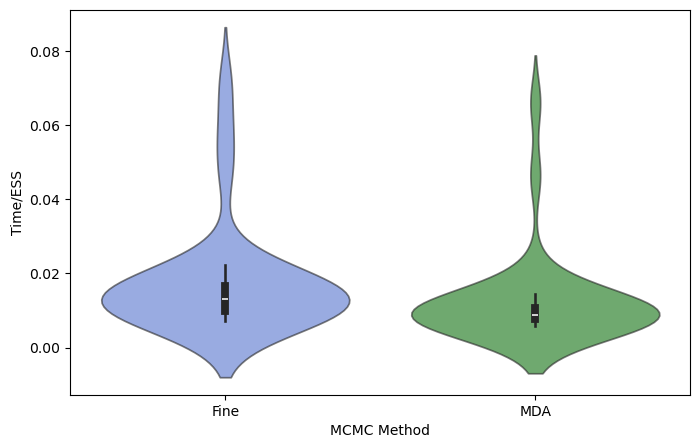

In [76]:
data = [Time_ESS_fine, Time_ESS_mda]

# Labels for the datasets
labels = ['Fine', 'MDA']

# Create the violin plot
plt.figure(figsize=(8, 5))
sns.violinplot(data=data, palette=['royalblue', 'green'], alpha=0.6)
plt.xticks([0, 1], labels)
plt.xlabel('MCMC Method')
plt.ylabel('Time/ESS')
#plt.title('Violin Plot of Time/ESS for Fine model and MDA')
plt.show()

In [77]:
np.mean(Time_ESS_fine)/np.mean(Time_ESS_mda)

1.399729082247512